### **SkillFactory**
### **Курс** Специализация Data Science

## <center> Дипломный проект. Часть 2

# <center> «Модель прогнозирования
# <center> стоимости жилья для агентства недвижимости»

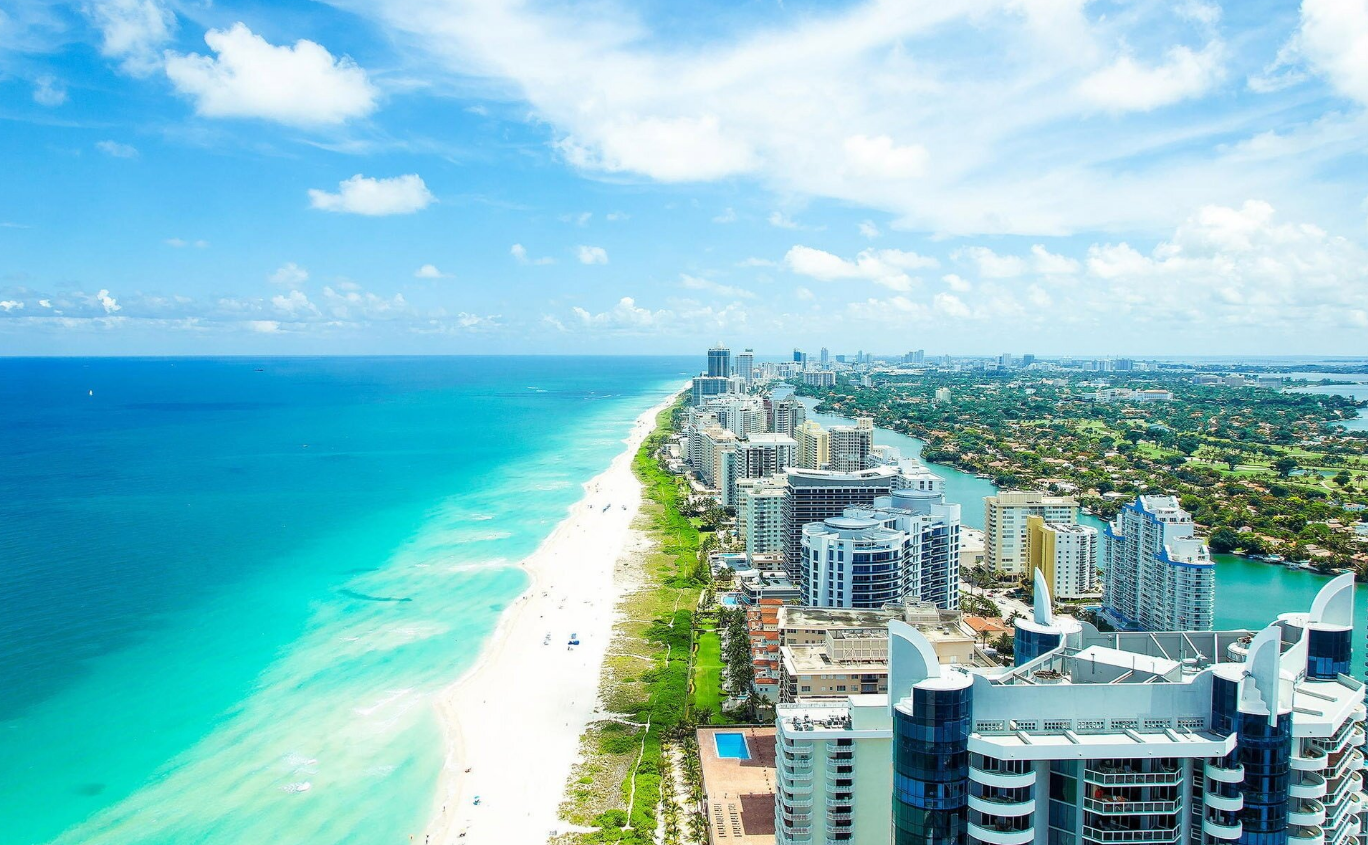
    
**Ваша задача** — разработать модель, которая позволила бы агентству
недвижимости обойти конкурентов по скорости и качеству совершения
сделок.

Вам необходимо:
1. Провести разведывательный анализ и очистку исходных данных. Обратите внимание, что данные в таблице реальные: в результате во многих признаках присутствуют ублирующиеся категории, ошибки ввода, жаргонные сокращения и т.д. Вам предстоит отыскать закономерности, самостоятельно расшифровать все сокращения, найти синонимы в данных, обработать пропуски и удалить выбросы. Постарайтесь уделить этапу очистки максимум внимания, так как это напрямую повлияет на результаты моделирования. 

2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.

3. Построить модель для прогнозирования стоимости недвижимости.

4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

**Описание данных:**
* 'status' — статус продажи;
* 'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' — тип объекта недвижимости;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
* 'fireplace' — наличие камина;
* 'city' — город;
* 'schools' — сведения о школах в районе;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'beds' — количество спален;
* 'state' — штат;
* 'stories' — количество этажей;
* 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
* 'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).




___

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении стоимости объектов недвижимости;
* Дополним наш анализ визуализациями, иллюстрирующими исследование.

Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
import category_encoders as ce
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import feature_selection
import optuna

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
import pickle

# Зафиксируем версию пакетов
!pip freeze > requirements.txt

***Функция, для расчёта метрик:***

1. MAE - средняя абсолютная ошибка в долларах
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [2]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

Прочитаем наш очищенный файл:

In [3]:
dtype_dict = {
   'status': 'object',
   'baths': 'float',
   'city': 'object',
   'sqft': 'int16',  
   'zipcode': 'object',
   'state': 'object', 
   'target': 'int32',  
   'property_type': 'object',
   'year_built_category': 'object', 
   'is_remodeled': 'int8',   
   'central_heating': 'int8', 
   'num_of_schools': 'int8',  
   'average_rating': 'int8',
   'average_distance_to_school': 'int8'   
} 
  
data = pd.read_csv('data/cleaned_data.csv', dtype=dtype_dict)
display(data.head())
data.info()

status  baths            city  sqft zipcode state  target  property_type  \
0  for sale    3.5  southern pines  2900   28387    NC  418000  single family   
1  for sale    3.0  spokane valley  1947   99216    WA  310000  single family   
2  for sale    2.0      mason city  3588   50401    IA  244900  single family   
3  for sale    3.0         houston  1930   77080    TX  311995  single family   
4  for sale    2.0        flushing  1300   11354    NY  669000    cooperative   

  year_built_category  is_remodeled  num_of_schools  average_rating  \
0           2001-2025             0               8               5   
1           2001-2025             0               3               4   
2           1951-1975             0               6               4   
3           2001-2025             0               3               3   
4           1951-1975             0               3               7   

   average_distance_to_school  central_heating  
0                           6                0  
1                           1                1  
2                           6                1  
3                           1                0  
4                           2                0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128063 entries, 0 to 128062
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   status                      128063 non-null  object 
 1   baths                       128063 non-null  float64
 2   city                        128063 non-null  object 
 3   sqft                        128063 non-null  int16  
 4   zipcode                     128063 non-null  object 
 5   state                       128063 non-null  object 
 6   target                      128063 non-null  int32  
 7   property_type               128063 non-null  object 
 8   year_built_category         128063 non-null  object 
 9   is_remodeled                128063 non-null  int8   
 10  num_of_schools              128063 non-null  int8   
 11  average_rating              128063 non-null  int8   
 12  average_distance_to_school  128063 non-null  int8   
 13  central_heatin

Начинаем с целевого признака. 

### 3.1
Построим гистограмму и коробчатую диаграмму стоимости недвижимости.

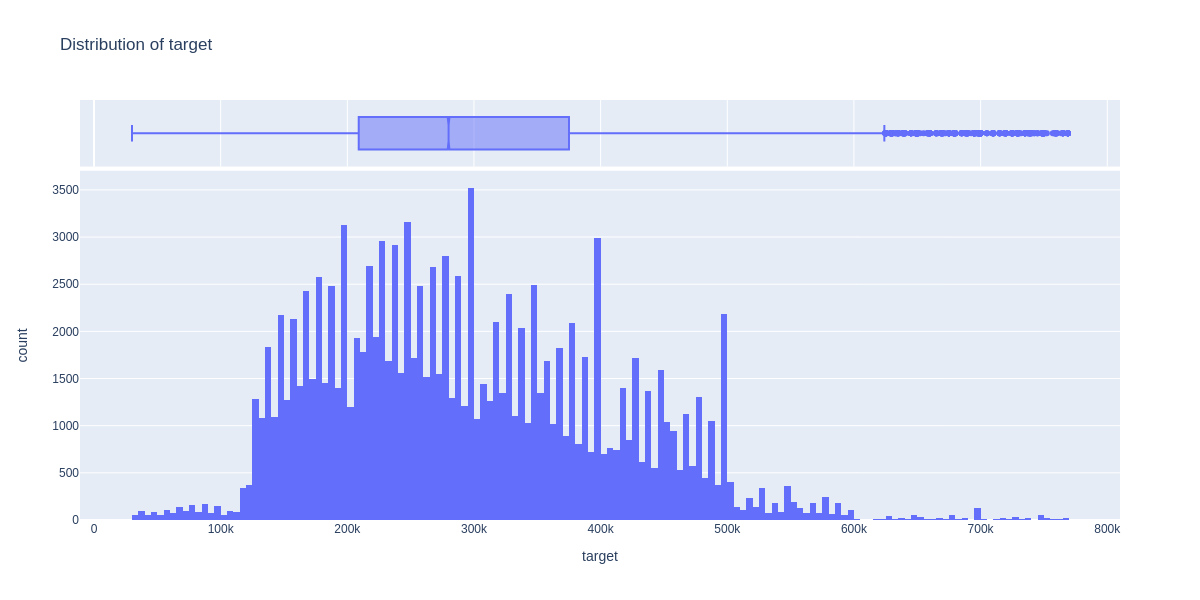

In [4]:
# Посморим на распределение стоимости объектов недвижимости
fig = px.histogram(
    data,
    x='target',
    #color="",
    title="Distribution of target",
    width=1200,
    height=600,
    marginal='box',  
    #histnorm='percent' 
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_17.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

Распределение всё ещё имеет правостороннюю асимметрию. 

### 3.2

Посмотрим на распределение стоимости объектов недвижимости в зависимости от их типа.

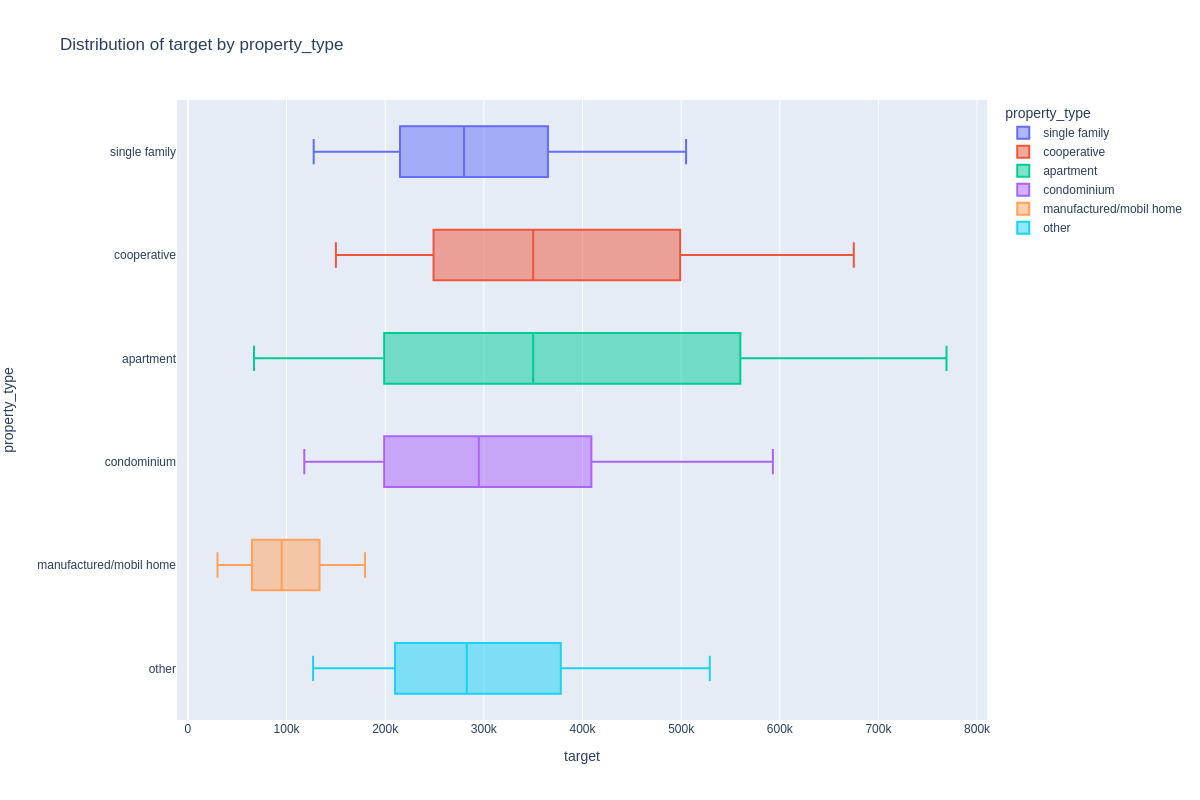

In [5]:
fig = px.box(
    data_frame=data,
    x='target',
    y='property_type',
    color='property_type',
    title='Distribution of target by property_type',
    width=1200,
    height=800
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_18.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

In [6]:
data[data['target'] > 700000] 

status  baths         city  sqft zipcode state  target  \
331     for sale    1.0     pasadena  1892   91103    CA  769000   
678     for sale    4.0     brooklyn  2814   11203    NY  704900   
3393    for sale    4.0  los angeles  2378   90032    CA  730000   
3506    for sale    3.0     brooklyn  2000   11207    NY  749999   
3585    for sale    2.0   sacramento  1981   95811    CA  769000   
...          ...    ...          ...   ...     ...   ...     ...   
124791  for sale    2.0     brooklyn  1540   11229    NY  738000   
124859  for sale    2.0  los angeles  1585   90018    CA  760000   
126855  for sale    3.0      jamaica  1648   11422    NY  729000   
127465  for sale    2.0    san pedro  1742   90731    CA  719900   
127565  for sale    2.0      oakland  1896   94607    CA  749000   

       property_type year_built_category  is_remodeled  num_of_schools  \
331        apartment           1976-2000             0               8   
678        apartment           2001-2025             0               3   
3393       apartment           1901-1925             0               8   
3506       apartment           1901-1925             1               1   
3585       apartment           1801-1900             0               2   
...              ...                 ...           ...             ...   
124791     apartment           1951-1975             1               2   
124859     apartment           1901-1925             0               3   
126855     apartment           1901-1925             1               4   
127465     apartment           1926-1950             1               3   
127565     apartment           1801-1900             1               3   

        average_rating  average_distance_to_school  central_heating  
331                  3                           1                0  
678                  6                           1                0  
3393                 4                           1                0  
3506                 5                           0                0  
3585                 8                           2                1  
...                ...                         ...              ...  
124791               4                           0                0  
124859               2                           1                0  
126855               3                           1                0  
127465               4                           1                0  
127565               2                           1                0  

[228 rows x 14 columns]

Диаграмма подтверждает зависимость стоимости от типа объектов недвижимости. Самыми бюджетными являются мобильные дома, а дорогими - квартиры в штатах Нью-Йорк и Калифорния.

В процессе очистки приизнаков из данных пропала категория пентхаус, она действительно была малочисленной и такое вполне возможно.

### 3.3
Посмотрим на распределение стоимости объектов недвижимости в зависимости от периода постройки.

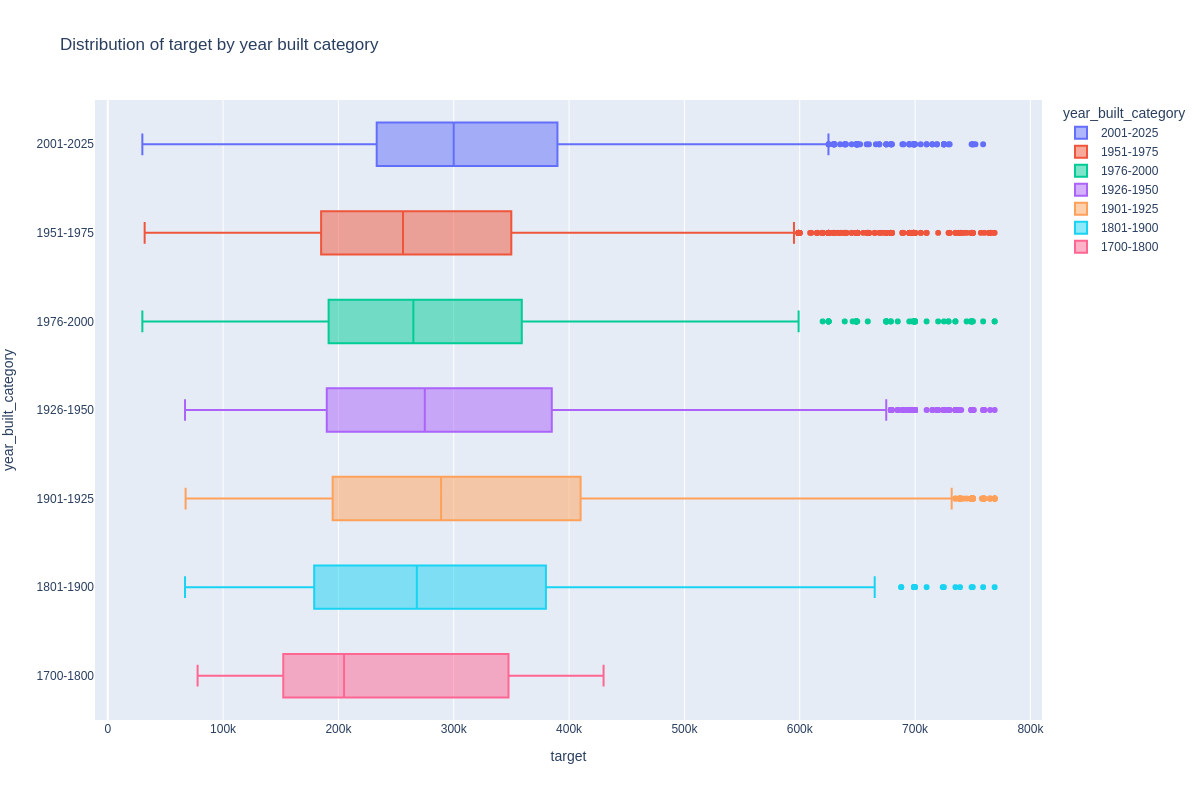

In [7]:
fig = px.box(
    data_frame=data,
    x='target',
    y='year_built_category',
    color='year_built_category',
    title='Distribution of target by year built category',
    width=1200,
    height=800
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_19.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

Тут также наблюдается некоторая закономерность. Самая высокая медианная стоимость у современных объектов.

### 3.4
Посмотрим на распределение стоимости объектов недвижимости в зависимости от штата.

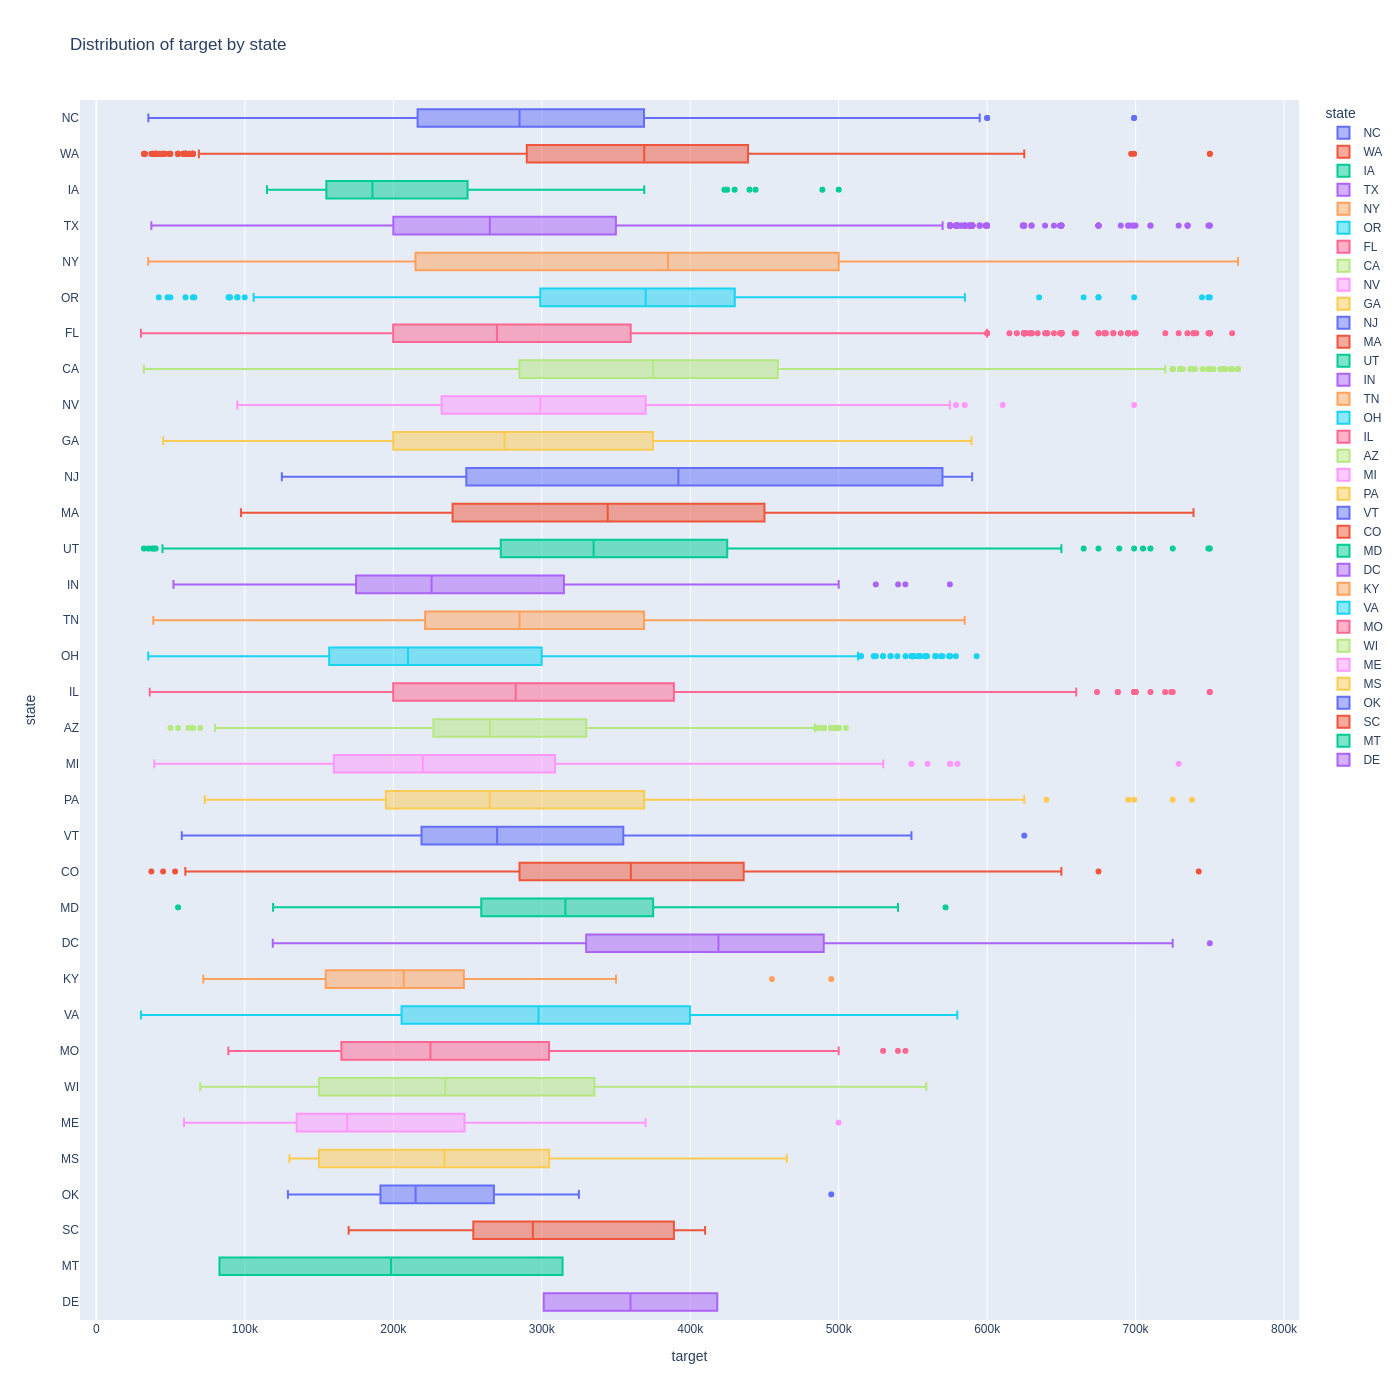

In [8]:
fig = px.box(
    data_frame=data,
    x='target',
    y='state',
    color='state',
    title='Distribution of target by state',
    width=1400,
    height=1400
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_20.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

Диаграмма также подтверждает зависимость стоимости от штата. Самая высокая медианная стоимость жилья в штатах Колумбия, Нью-Йорк, в соседнем Нью-Джерси (5 округов штата входят в число округов с самым высоким доходом в США), Калифорния.

### 3.5
Посмотрим на распределение стоимости объектов недвижимости в зависимости от статуса.

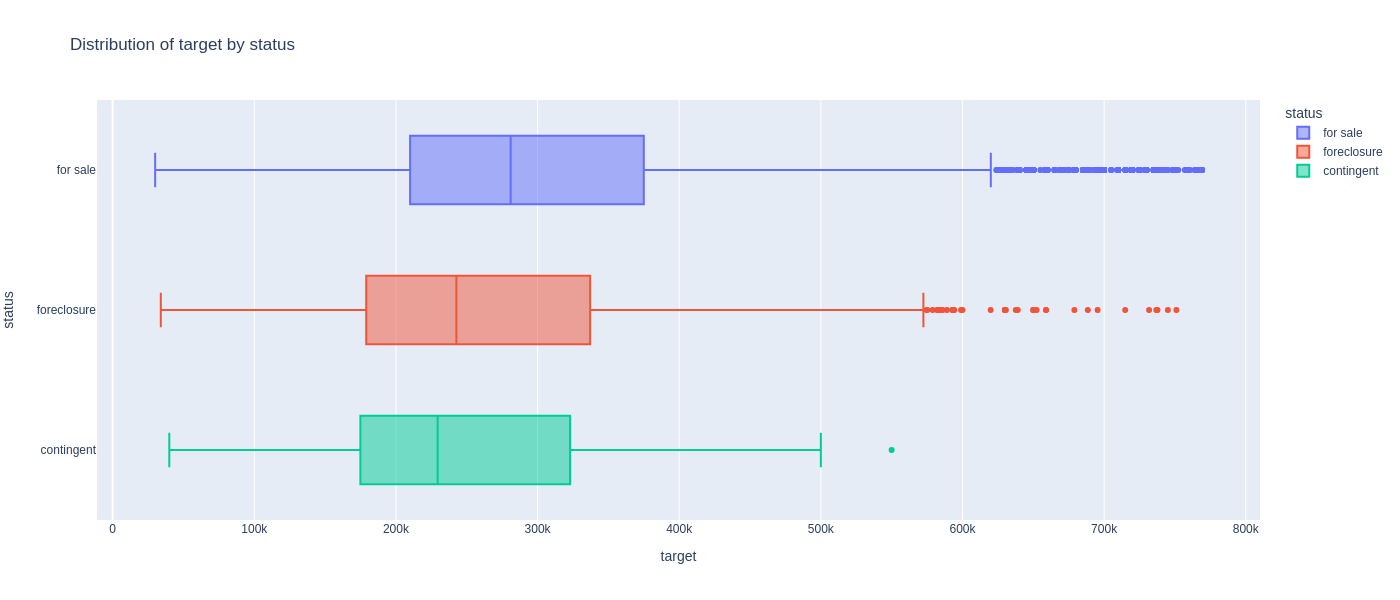

In [9]:
fig = px.box(
    data_frame=data,
    x='target',
    y='status',
    color='status',
    title='Distribution of target by status',
    width=1400,
    height=600
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_21.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

На этом графике тоже всё закономерно, более низкая медианная стоимость у объектов с особыми условиями продажи и отягощёнными юридическими проблемами (неуплата взносов, налогов, конфискаты, продающиеся с аукциона).

### 3.6
Посмотрим на распределение стоимости объектов недвижимости в зависимости от города.

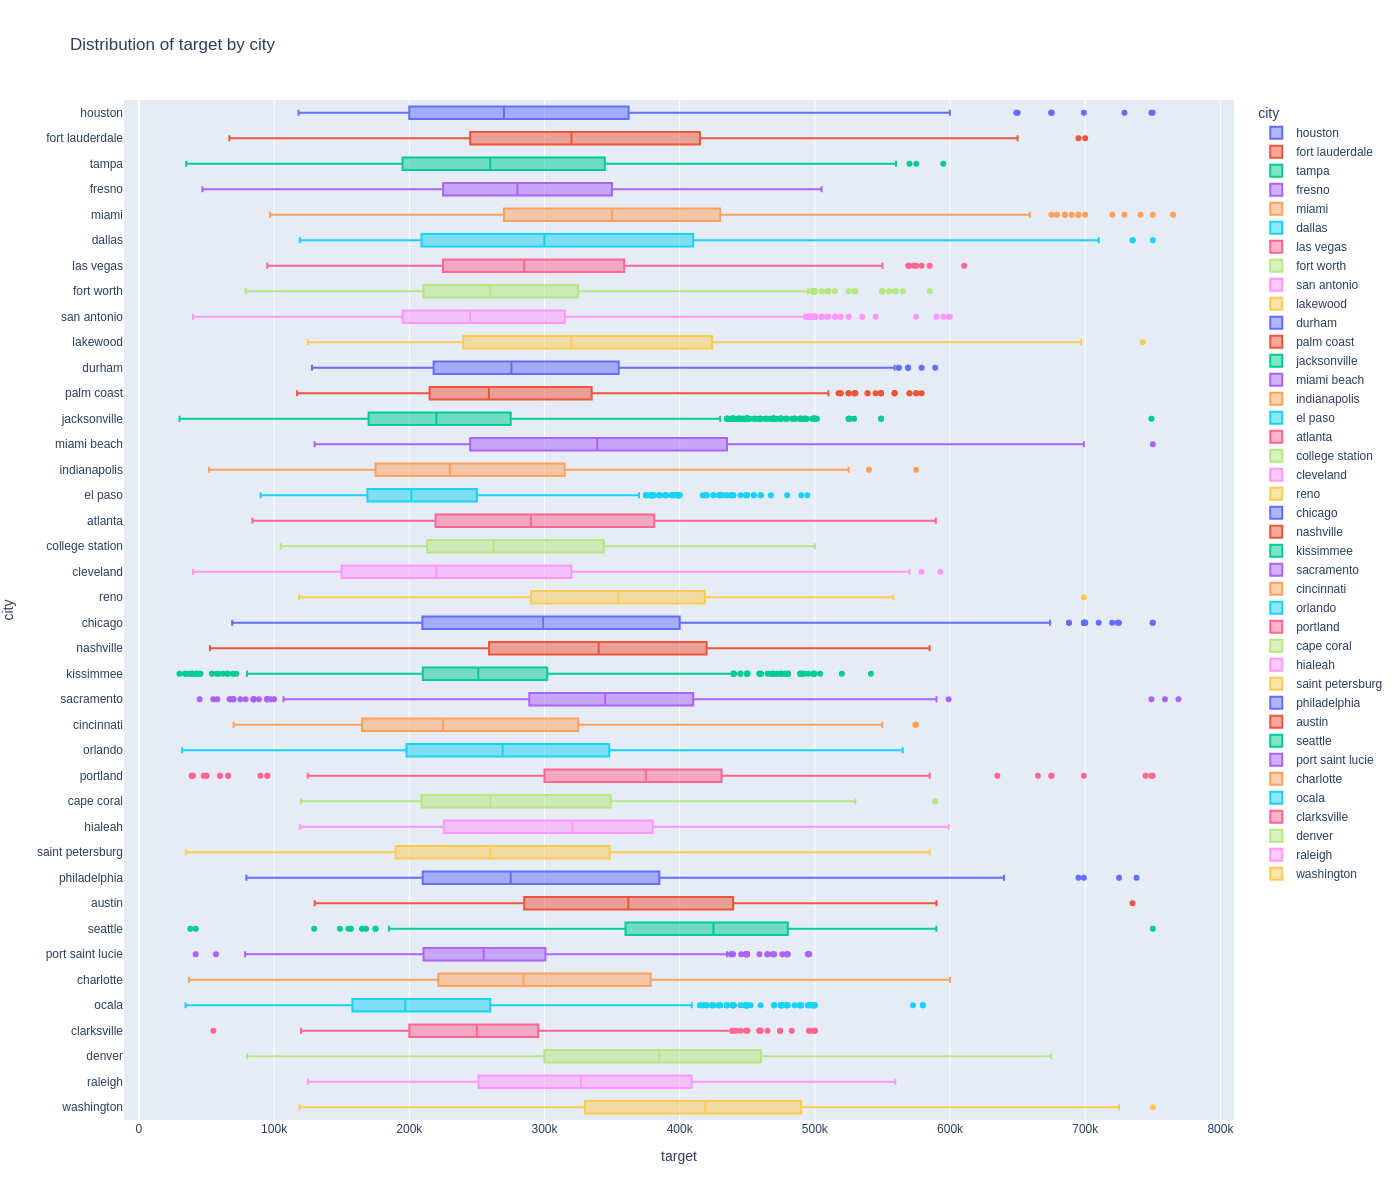

In [10]:
fig = px.box(
    data_frame=data.loc[data.loc[:, 'city'].isin(data['city'].value_counts().index[:40])],
    x='target',
    y='city',
    color='city',
    title='Distribution of target by city',
    width=1400,
    height=1200
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_22.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

Диаграмма также подтверждает, что цена сильно зависит от города. Заметно отличается медианная стоимость объектов в Вашингтоне.

### 3.7
Посмотрим на распределение стоимости объектов недвижимости в зависимости от района (почтового индекса).

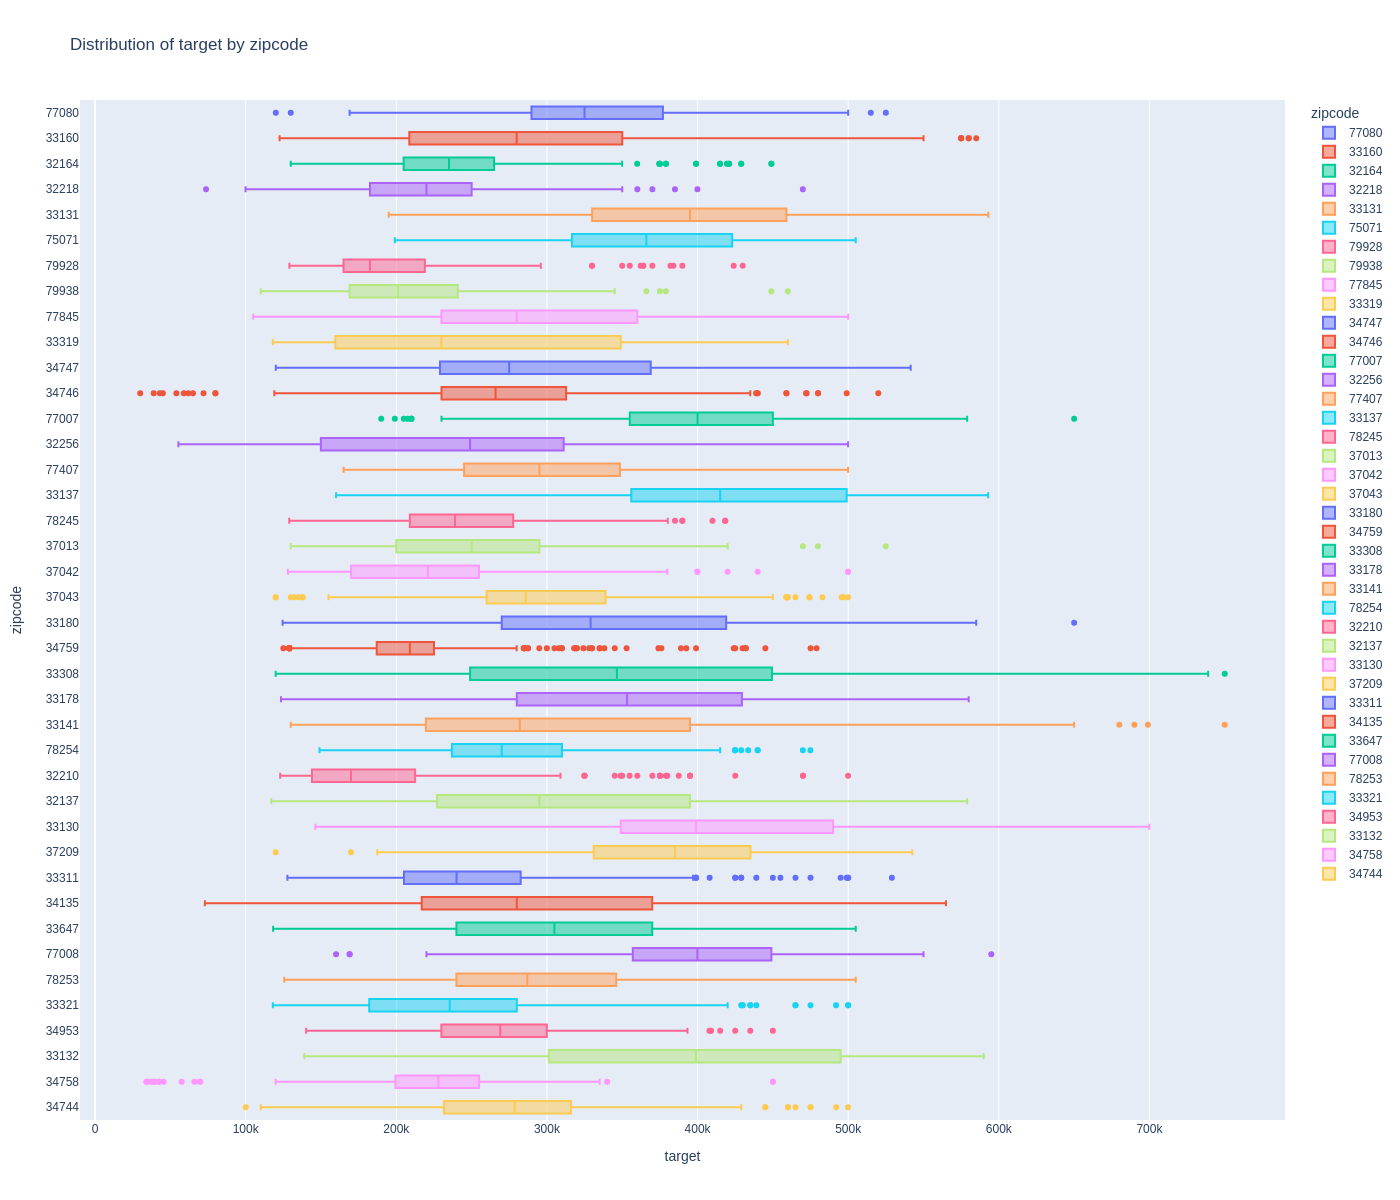

In [11]:
fig = px.box(
    data_frame=data.loc[data.loc[:, 'zipcode'].isin(data['zipcode'].value_counts().index[:40])],
    x='target',
    y='zipcode',
    color='zipcode',
    title='Distribution of target by zipcode',
    width=1400,
    height=1200
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_23.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

На этой диаграмме видно, что самые дорогие объекты расположены в элитных районах побережья Флориды.

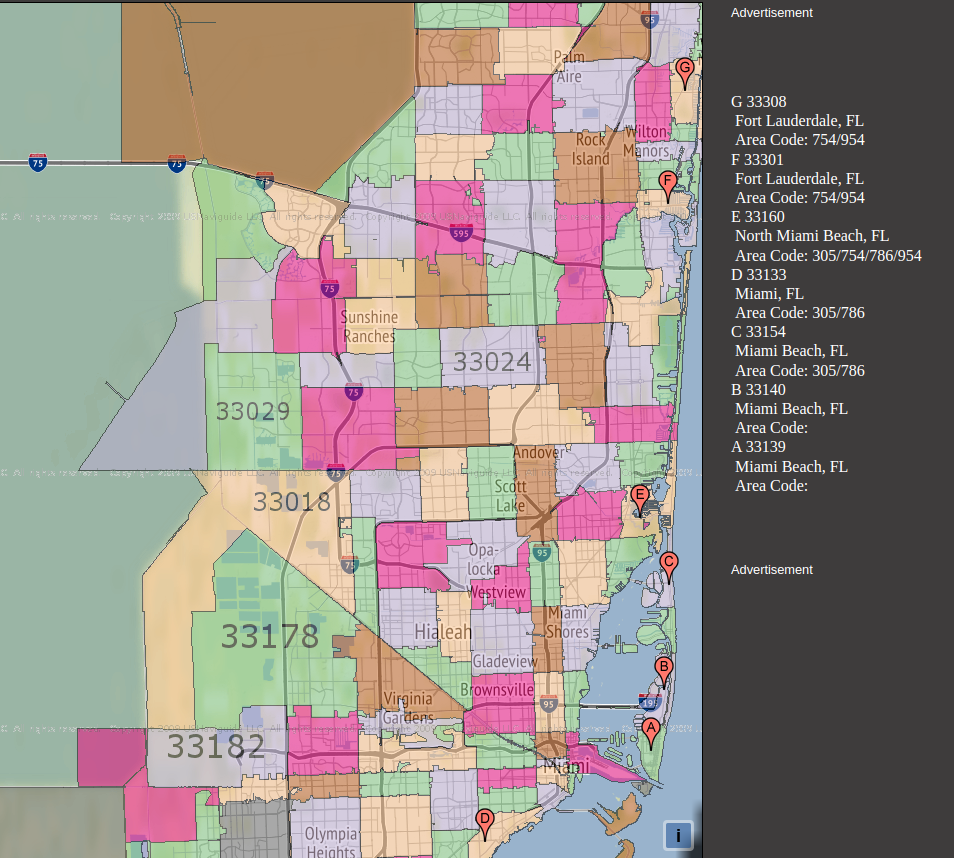

### 3.8.

Посмотрим как зависит медианная стоимость от типа объектов недвижимости в разных штатах.

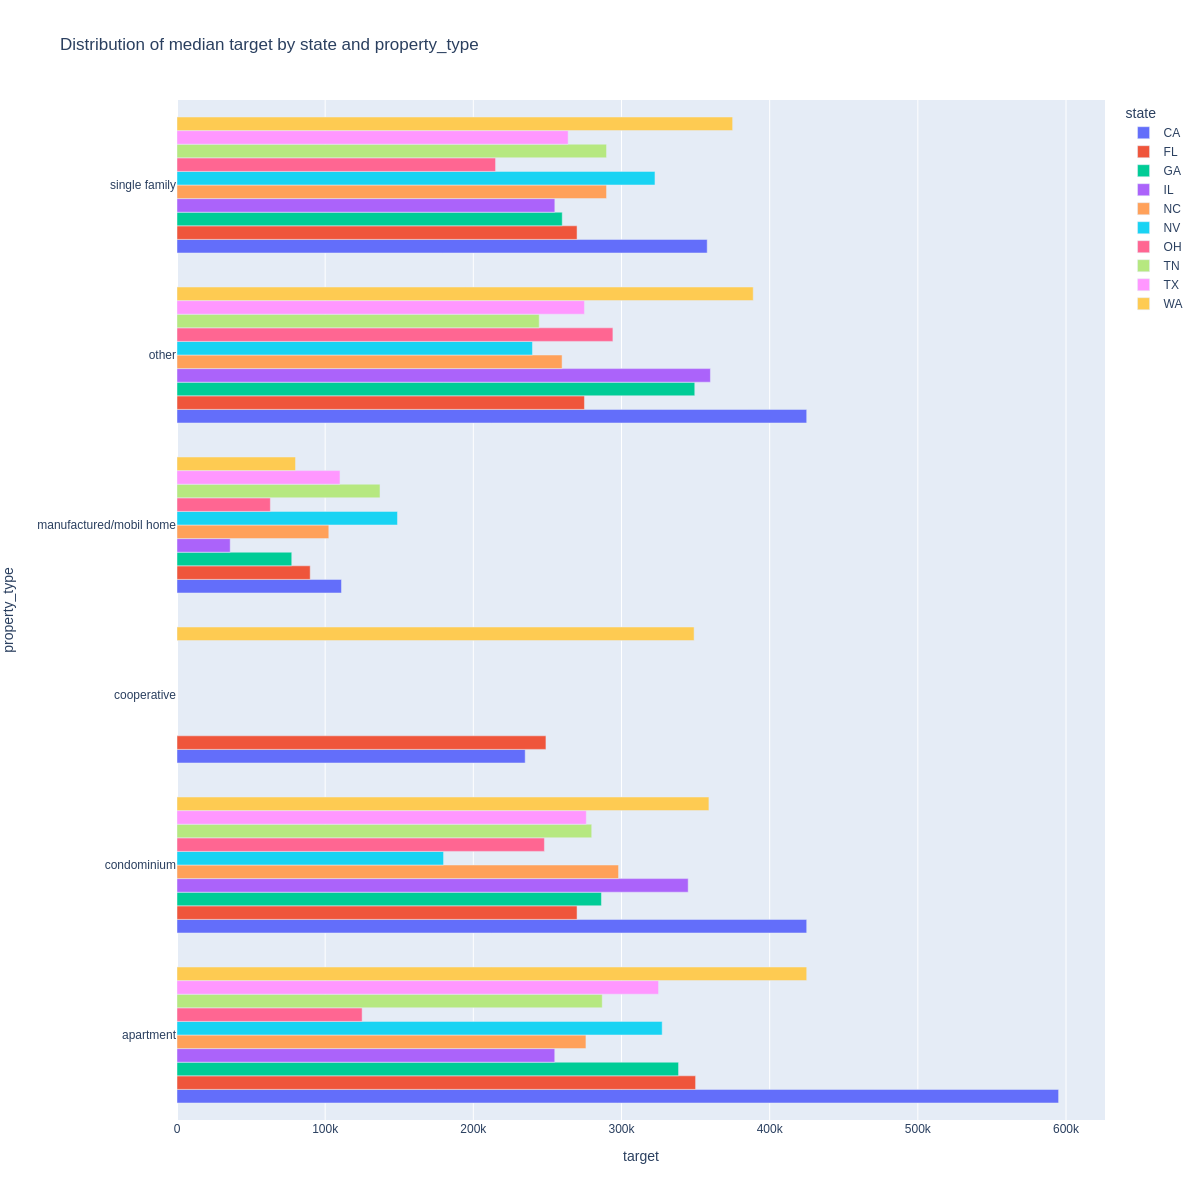

In [12]:
bar_data = data.loc[data.loc[:, 'state'].isin(data['state'].value_counts().index[:10])].groupby(['state', 'property_type'], as_index=False)['target'].median()

fig = px.bar(
    data_frame=bar_data,
    x='target',
    y='property_type',
    color='state',
    title='Distribution of median target by state and property_type',
    width=1200,
    height=1200,
    barmode="group"  
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_24.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

Эта столбчатая диаграмма также демонстрирует зависимость стоимости жилья от типа недвижимости и штата.

### 3.9
Посмотрим, как много предложений по типам недвижимости в зависимости от штата.

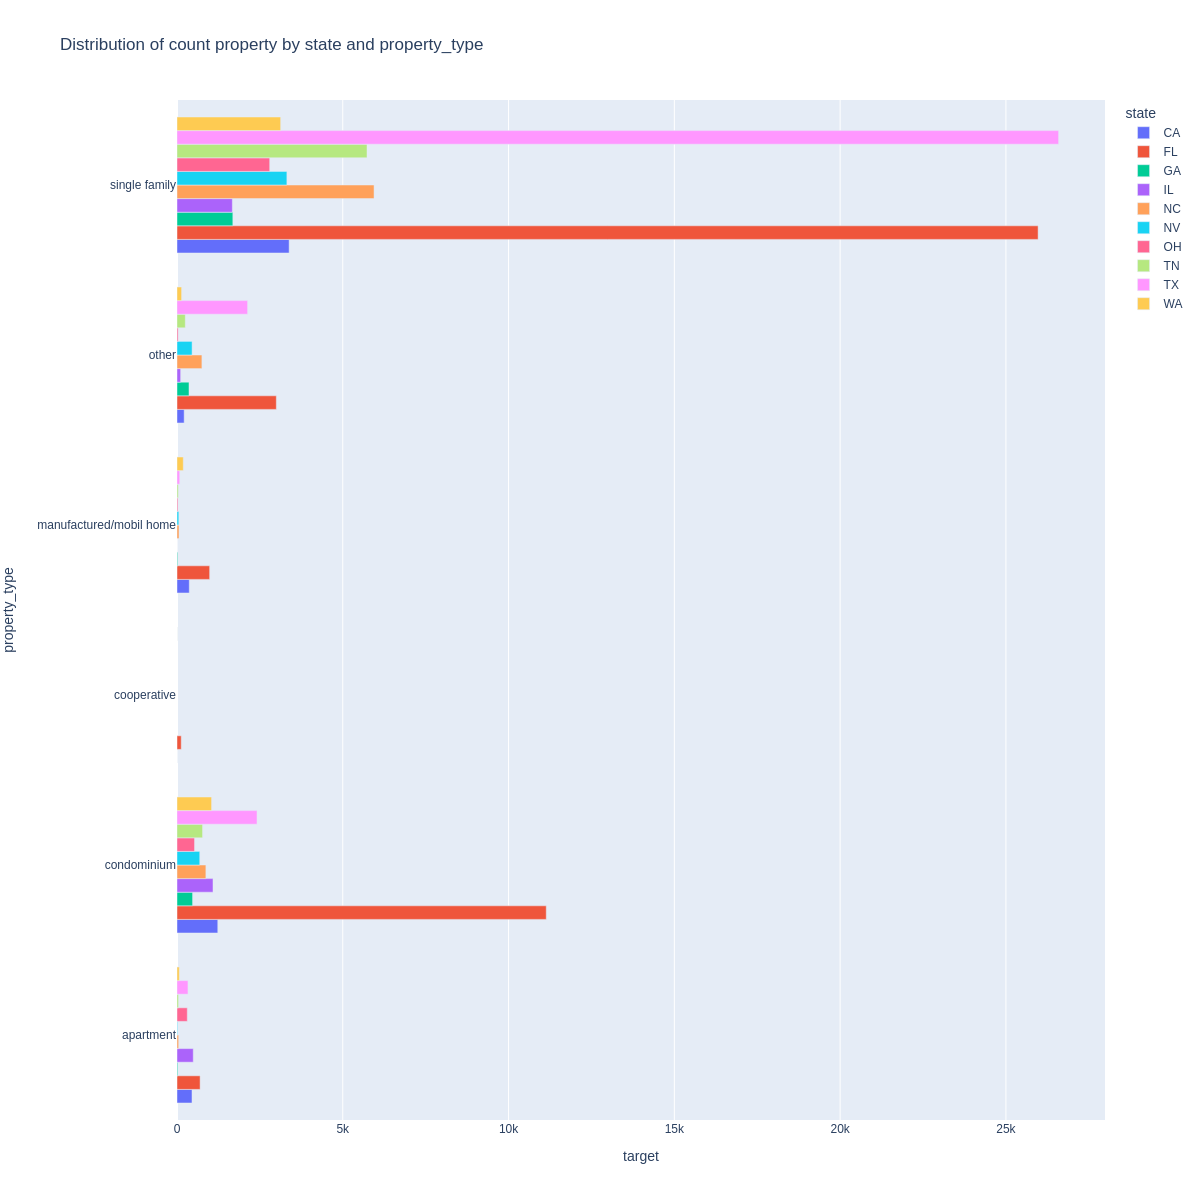

In [13]:
bar1_data = data.loc[data.loc[:, 'state'].isin(data['state'].value_counts().index[:10])].groupby(['state', 'property_type'], as_index=False)['target'].count()
fig = px.bar(
    data_frame=bar1_data,
    x='target',
    y='property_type',
    color='state',
    title='Distribution of count property by state and property_type',
    width=1200,
    height=1200,
    barmode="group"   
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_25.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

Во всех штатах преобладают предложения покупки домов, больше всего предложений во Флориде и Техасе.

### 3.10

Посмотрим влияет ли реконструкция домов на их медианную стоимость в разрезе признака год постройки.

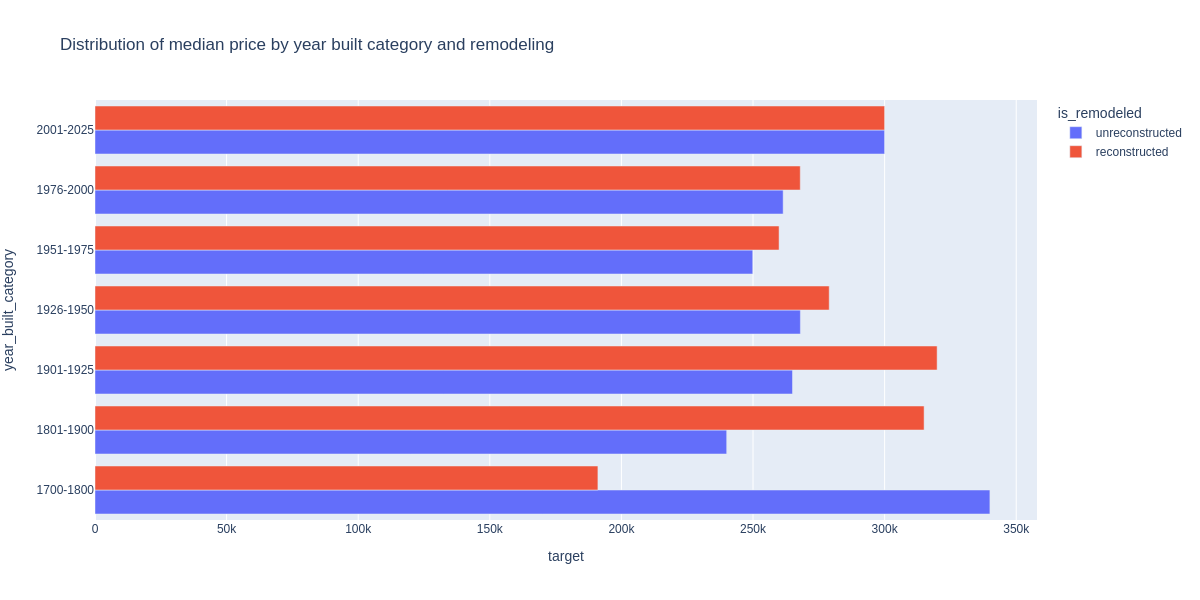

In [14]:
remodeling_data = data.groupby(['is_remodeled', 'year_built_category'], as_index=False)['target'].median()
remodeling_data['is_remodeled'] = remodeling_data['is_remodeled'].map({0 : 'unreconstructed', 1 : 'reconstructed'})

fig = px.bar(
    data_frame=remodeling_data,
    x='target',
    y='year_built_category',
    color='is_remodeled',
    title='Distribution of median price by year built category and remodeling',
    width=1200,
    height=600,
    barmode="group"  
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_26.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

На столбчатой диаграмме всё выглядит логично, за исключением соотношения медианной стоимости для самых старых объектов. Возможно причина в некорректности заполнения пустых значений в этом сегменте или немногочисленности группы. Вполне понятно, что для относительно новых строений признак наличия реконструкции неважен, но чем старше объект, тем заметнее разница в медианной стоимости между реконструированными и нереконструированными объектами.

### 3.11
Посмотрим на попарную зависимость оставшихся числовых признаков между собой, в том числе и с целевым.

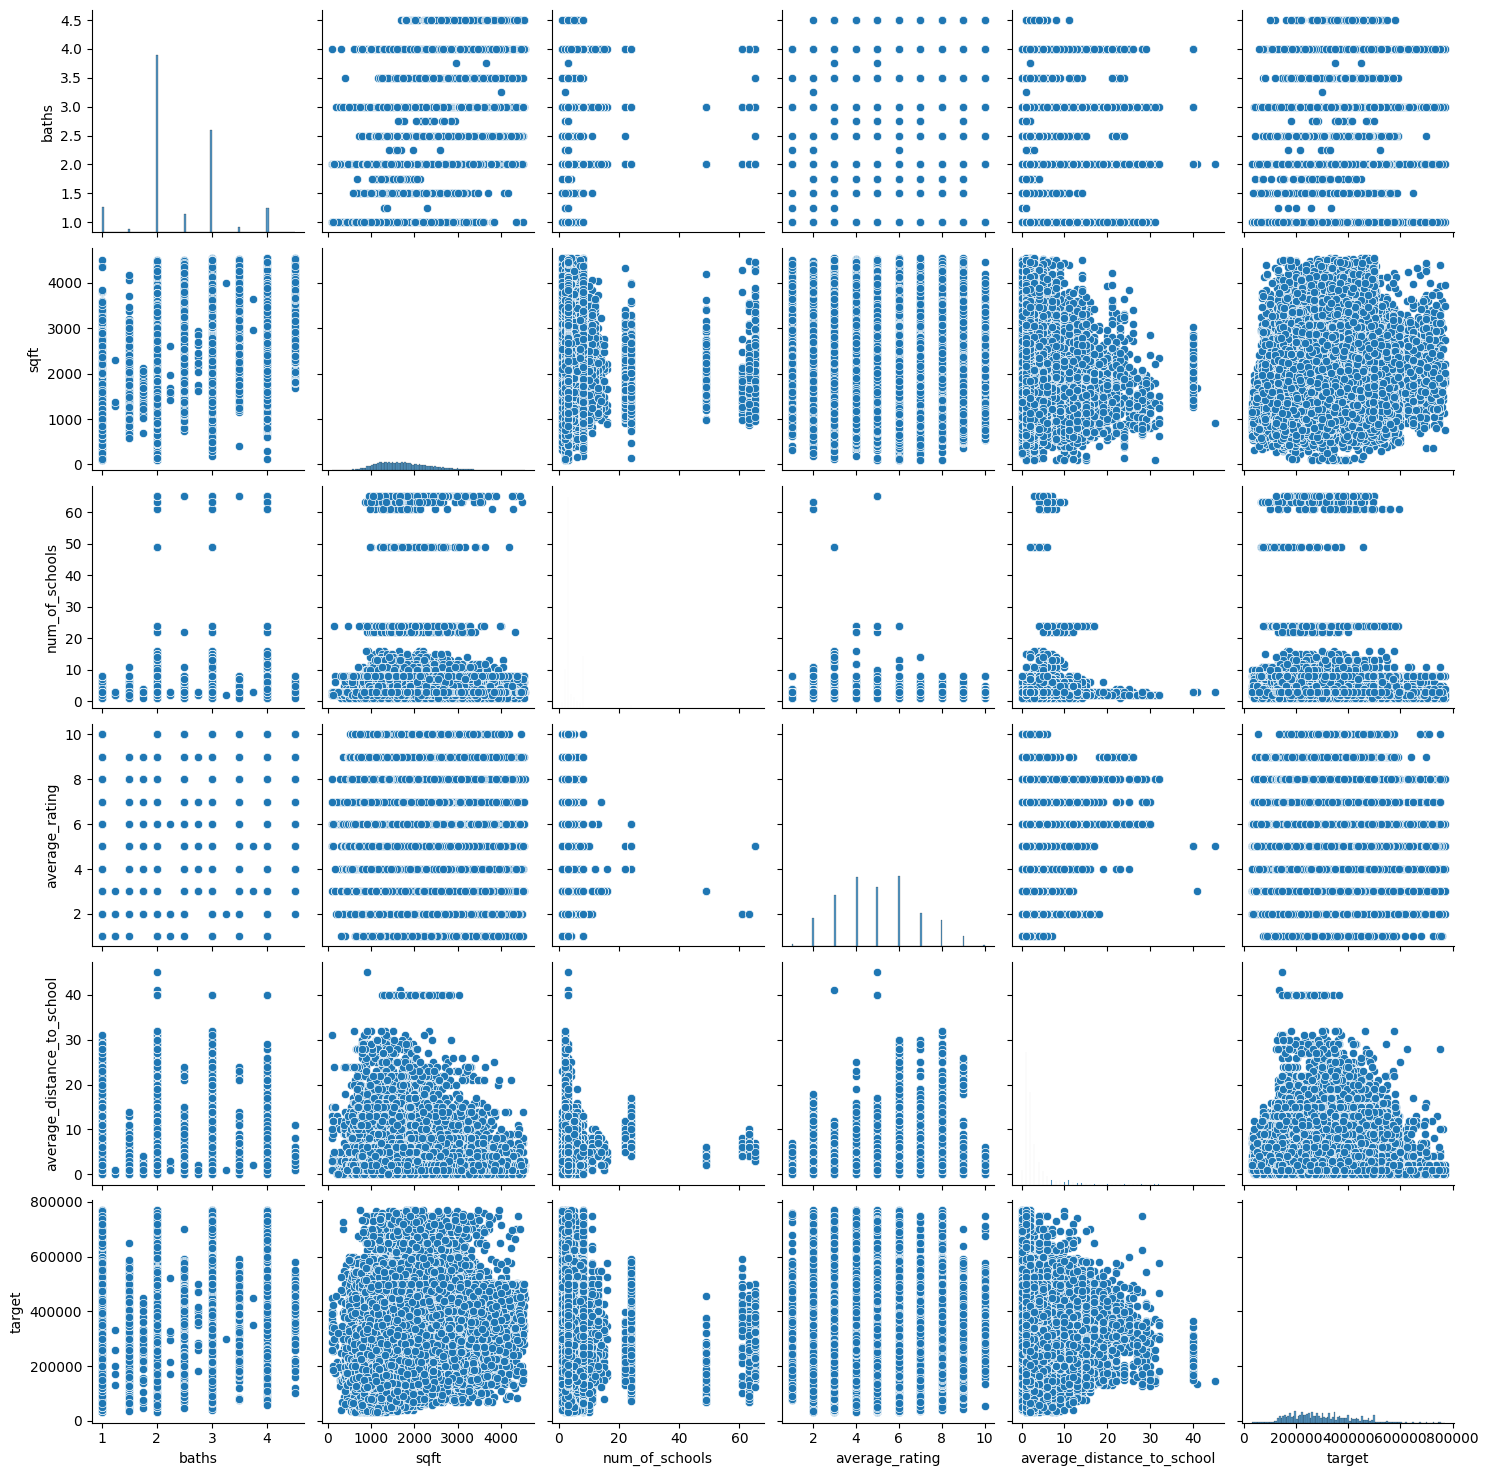

In [15]:
# Cоздадим список числовых признаков
num_cols = ['baths', 'sqft', 'num_of_schools', 'average_rating', 'average_distance_to_school']

# Cоздадим список числовых признаков с целевой переменной
corr_num_cols = num_cols.copy()
corr_num_cols.append('target')
sns.pairplot(data[corr_num_cols])

Явной попарной линейной зависимости между признаками, в том числе с целевой переменной визуально обнаружить не удалось.

Из числовых признаков все, кроме *baths* являются непрерывными. *baths* - числовой дискретный, может принимать только целые или дробные, кратные 0,25, кодироваться не будет.

Посмотрим на распределения и описательные статистики числовых признаков.

baths           sqft         target   is_remodeled  \
count  128063.000000  128063.000000  128063.000000  128063.000000   
mean        2.398626    1834.706613  295976.874140       0.459547   
std         0.725942     689.222470  112674.798151       0.498363   
min         1.000000      90.000000   30000.000000       0.000000   
25%         2.000000    1318.000000  209000.000000       0.000000   
50%         2.000000    1728.000000  279950.000000       0.000000   
75%         3.000000    2245.000000  375000.000000       1.000000   
max         4.500000    4546.000000  769000.000000       1.000000   

       num_of_schools  average_rating  average_distance_to_school  \
count   128063.000000   128063.000000               128063.000000   
mean         4.316540        4.998883                    2.799622   
std          4.607642        1.863661                    3.281760   
min          1.000000        1.000000                    0.000000   
25%          3.000000        4.000000                    1.000000   
50%          3.000000        5.000000                    2.000000   
75%          4.000000        6.000000                    3.000000   
max         65.000000       10.000000                   45.000000   

       central_heating  
count    128063.000000  
mean          0.591029  
std           0.491646  
min           0.000000  
25%           0.000000  
50%           1.000000  
75%           1.000000  
max           1.000000

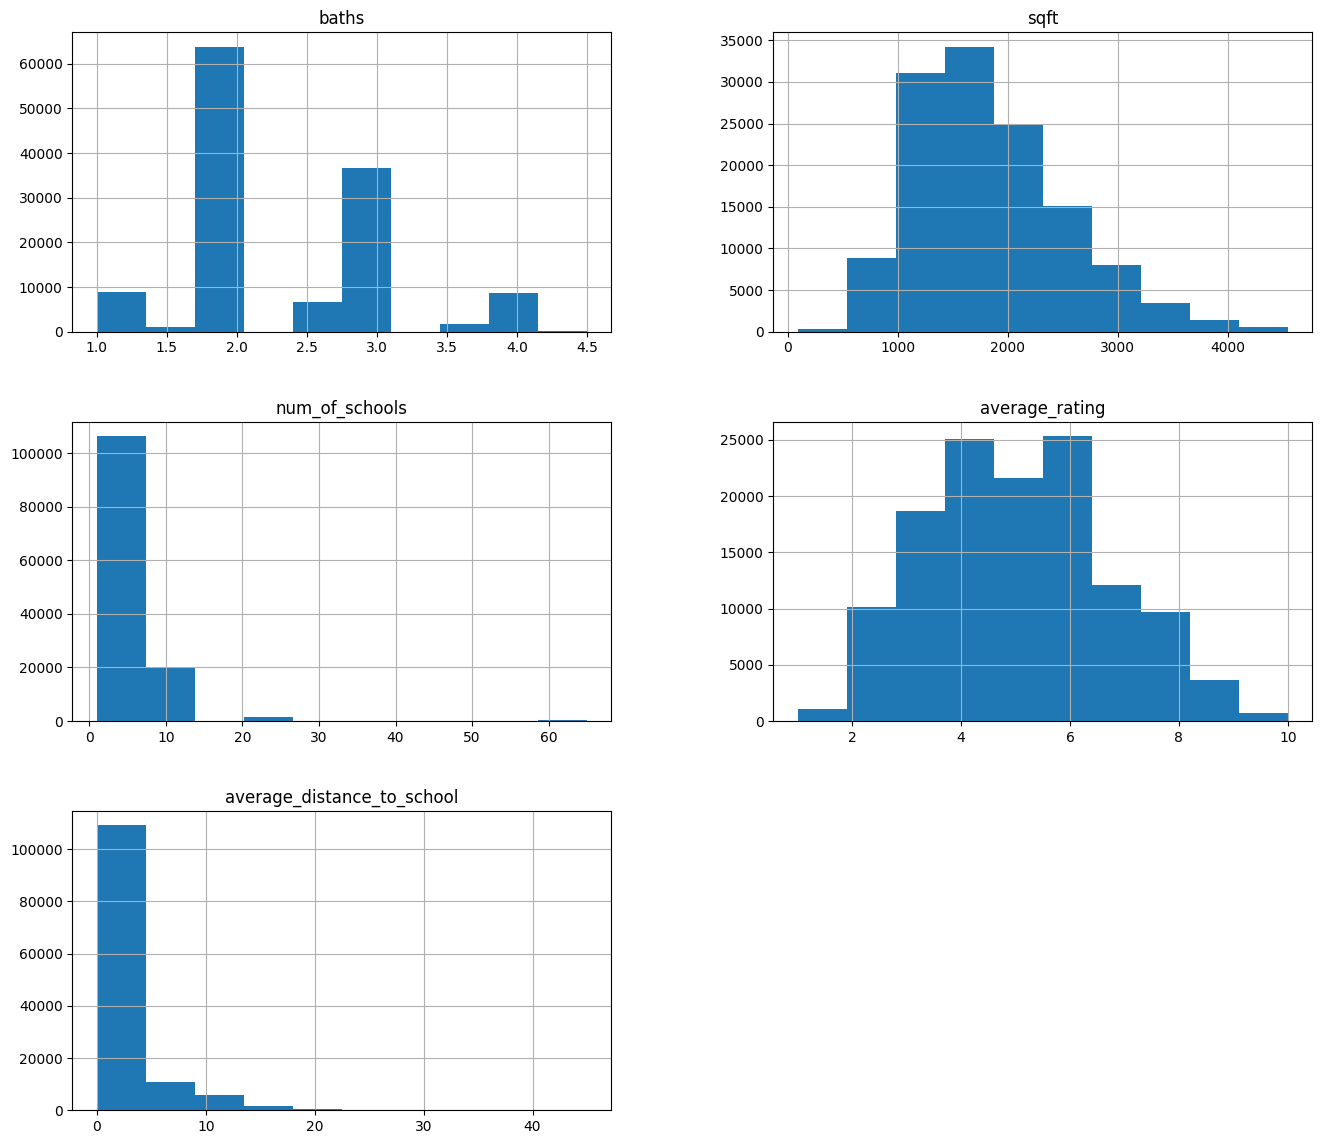

In [16]:
data[num_cols].hist(figsize=(16,14));

# Посмотрим на описательные статистики
display(data.describe())

In [17]:
# Cформулируем нулевую и альтернативную гипотезы
H0 = 'Данные распределены нормально.'
Ha = 'Данные не распределены нормально.'

# Выбираем уровень значимости
alpha = 0.05
for col in num_cols:
    _, p_value = stats.normaltest(data[col]) # normaltest возвращает двустороннюю вероятность для проверки гипотезы
    print(f"Признак {col}")
    # Интерпретация
    if p_value > alpha/2:
        print(f"p_value: {round(p_value, 2)} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}\n")
    else:
        print(f"p_value: {round(p_value, 2)} <= {alpha}. Мы отвергаем нулевую гипотезу. {Ha}\n")     

Признак baths
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак sqft
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак num_of_schools
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак average_rating
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак average_distance_to_school
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.



Числовые факторы имеют распределения отличные от нормального, а также отличаются масштабом. Поэтому их необходимо нормализовать. Несмотря на то, что данные прошли очистку, всё же распределения имеют явное правостороннее смещение. RobustScaler в вычислении использует перцентили, и поэтому не зависит даже от большого количества выбросов. Выберем этот способ нормализации данных.

___

## <center> 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели необходимо
* закодировать категориальные признаки;
* отобрать признаки, которые мы будем использовать для обучения модели;
* масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.

### 4.1 Кодирование признаков

Теперь займёмся кодированием категориальных признаков. В наших данных к категориальным можно отнести следующие признаки:

* *property_type*,
* *year_built_category*,
* *status*,
* *state*,
* *city*,
* *zipcode*,
* *central_heating*,
* *is_remodeled*

Признак *is_remodeled* и *central_heating* являеюся бинарными (имеет два уникальных значения). Остальные будем кодировать с помощью однократного и двоичного кодирований.

#### 4.1.1 Однократное кодирование

Закодируем однократным кодированием следующие признаки:

* *property_type*,
* *year_built_category*,
* *status*,

с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

In [18]:
data.columns

Index(['status', 'baths', 'city', 'sqft', 'zipcode', 'state', 'target',
       'property_type', 'year_built_category', 'is_remodeled',
       'num_of_schools', 'average_rating', 'average_distance_to_school',
       'central_heating'],
      dtype='object')

In [19]:
oh_cols_to_change = ['property_type', 'year_built_category', 'status']

oh_encoder = preprocessing.OneHotEncoder(drop='first')

# Обучаем и сразу применяем преобразование к выборке, результат переводим в массив
data_oh = oh_encoder.fit_transform(data[oh_cols_to_change]).toarray() 
# Запишем полученные названия новых колонок в отдельную переменную
column_names = oh_encoder.get_feature_names_out(oh_cols_to_change)
print(column_names)
data_oh = pd.DataFrame(data_oh, columns=column_names)
print(f"n\Размер data_oh: {data_oh.shape}")

# Добавим полученную таблицу с закодированными признаками:
data = pd.concat(
    [data.reset_index(drop=True).drop(oh_cols_to_change, axis=1), data_oh], 
    axis=1
)
print(f"Размер таблицы после добавления закодированных признаков: {data.shape}")

['property_type_condominium' 'property_type_cooperative'
 'property_type_manufactured/mobil home' 'property_type_other'
 'property_type_single family' 'year_built_category_1801-1900'
 'year_built_category_1901-1925' 'year_built_category_1926-1950'
 'year_built_category_1951-1975' 'year_built_category_1976-2000'
 'year_built_category_2001-2025' 'status_for sale' 'status_foreclosure']
n\Размер data_oh: (128063, 13)
Размер таблицы после добавления закодированных признаков: (128063, 24)


#### 4.1.2 Двоичное кодирование

Закодируем двоичным кодированием следующие признаки:

* *city*,
* *zipcode*
* *state*

с помощью BinaryEncoder из библиотеки category_encoders.

In [20]:
be_cols_to_change = ['city', 'zipcode', 'state']

be_encoder = ce.BinaryEncoder(be_cols_to_change)
data_be = be_encoder.fit_transform(data[be_cols_to_change])
print(f"n\Размер data_oh: {data_oh.shape}")
print(data_be.columns)

# Добавим полученную таблицу с закодированными признаками
data = pd.concat(
    [data.reset_index(drop=True).drop(be_cols_to_change, axis=1), data_be], 
    axis=1
)
print(f"n\Размер таблицы после добавления закодированных признаков: {data.shape}")

n\Размер data_oh: (128063, 13)
Index(['city_0', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6',
       'city_7', 'city_8', 'city_9', 'city_10', 'zipcode_0', 'zipcode_1',
       'zipcode_2', 'zipcode_3', 'zipcode_4', 'zipcode_5', 'zipcode_6',
       'zipcode_7', 'zipcode_8', 'zipcode_9', 'zipcode_10', 'zipcode_11',
       'state_0', 'state_1', 'state_2', 'state_3', 'state_4', 'state_5'],
      dtype='object')
n\Размер таблицы после добавления закодированных признаков: (128063, 50)


### 4.2 Анализ мультиколлиниарности

Построим корреляционную матрицу факторов, включив в неё целевой признак, и визуализируем её с помощью тепловой карты. 


#### 4.2.1 Анализ мультиколлиниарности числовых признаков

Числовые переменные распределены ненормально, поэтому используем для вычисления взаимосвязей коэффициент корреляции Спирмена.

Text(0.5, 1.0, 'Тепловая матрица корреляций числовых признаков')

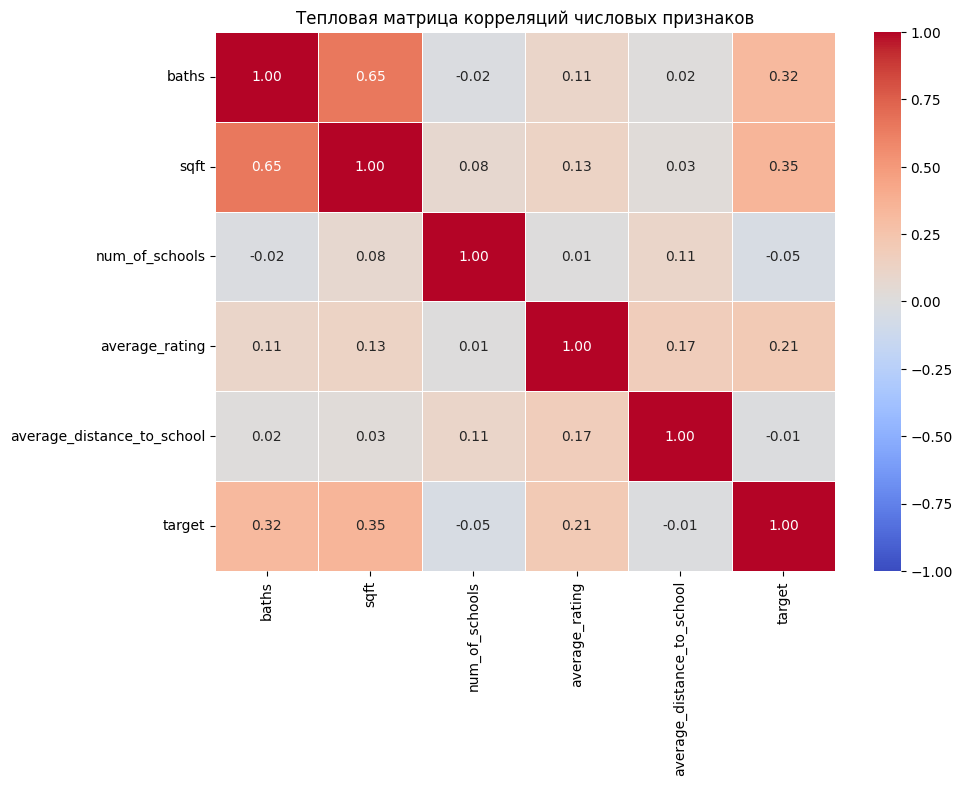

In [21]:
# Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
corr_num_matrix =data[corr_num_cols].corr(method='spearman', numeric_only = True)

# Построим тепловую карту корреляций признаков
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr_num_matrix, vmin=-1, vmax=1, center=0, annot=True, linewidths=.5, ax=ax, fmt='.2f', cmap= 'coolwarm')
ax.set_title('Тепловая матрица корреляций числовых признаков')

#### 4.2.2 Анализ мультиколлиниарности категориальных признаков

Text(0.5, 1.0, 'Тепловая матрица корреляций категориальных признаков')

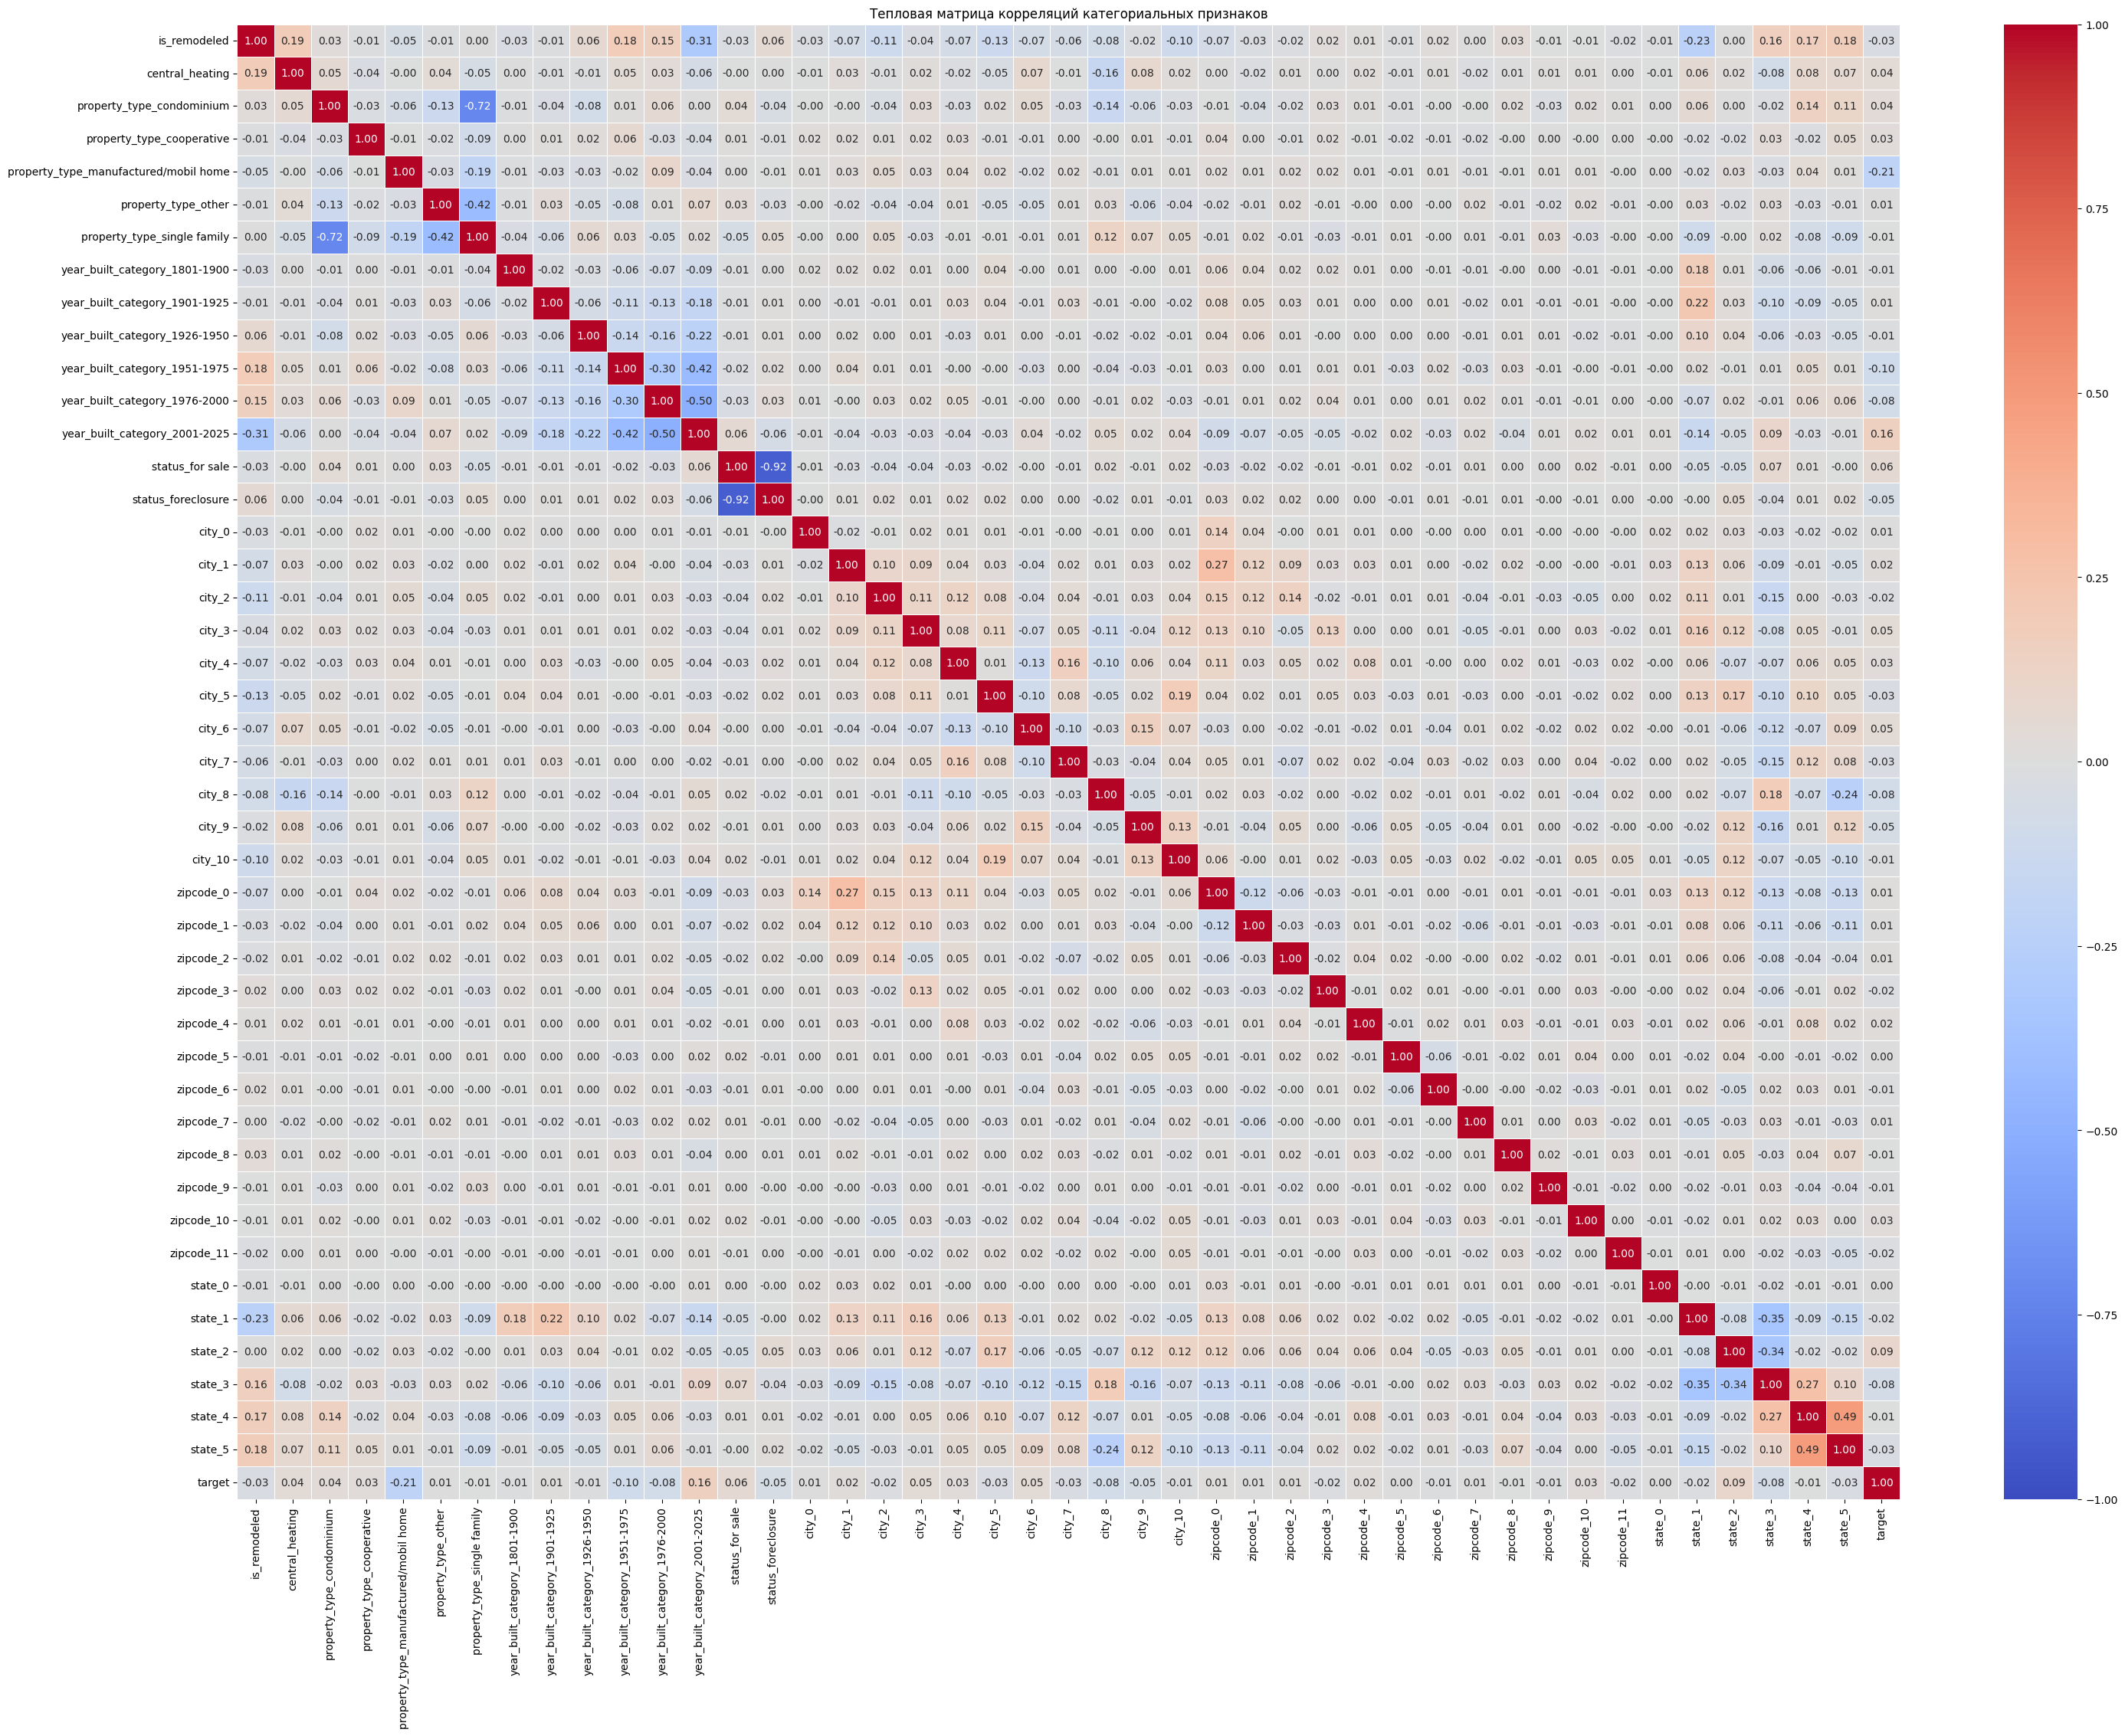

In [22]:
category_cols = [i for i in list(data.columns) if i not in corr_num_cols]
corr_category_cols = category_cols.copy()
corr_category_cols.append('target')
corr_category_cols

# Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
corr_category_matrix = data[corr_category_cols].corr(method='spearman', numeric_only=True)

# Построим тепловую карту корреляций признаков
fig, ax = plt.subplots(figsize=(35, 25))
sns.heatmap(corr_category_matrix, vmin=-1, vmax=1, center=0, annot=True, linewidths=.5, ax=ax, fmt='.2f', cmap= 'coolwarm')
ax.set_title('Тепловая матрица корреляций категориальных признаков')

Очень сильная корреляция наблюдается у признаков: 
* *status_for sale* и *status_foreclosure*,


Посмотрим на коэффициенты корреляции признаков с целевой переменной.

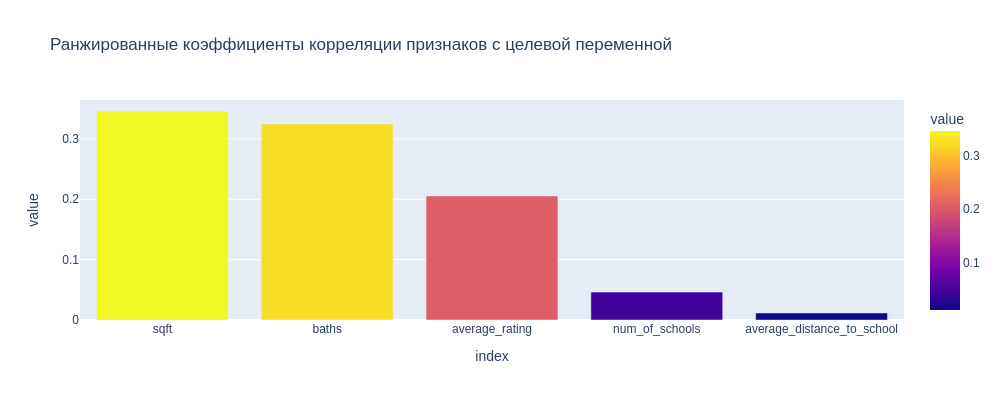

In [23]:
fig = px.bar(
    abs(corr_num_matrix)['target'].sort_values(ascending=False)[1:],
    color='value',
    width=1000,
    height=400,
    title='Ранжированные коэффициенты корреляции признаков с целевой переменной'
    )
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_27.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

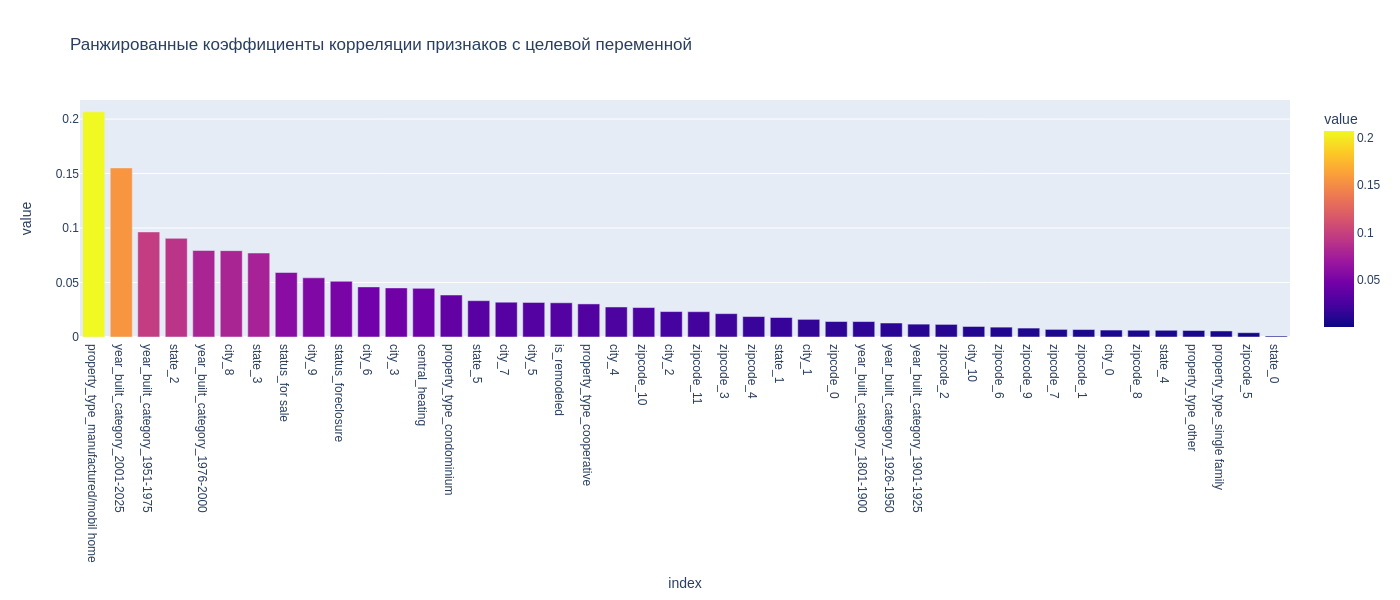

In [24]:
fig = px.bar(
    abs(corr_category_matrix)['target'].sort_values(ascending=False)[1:],
    color='value',
    title='Ранжированные коэффициенты корреляции признаков с целевой переменной',
    width=1400,
    height=600,
    )
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_28.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

*status_foreclosure* меньше коррелирует с целевой переменной, удалим его.

In [25]:
data = data.drop(['status_foreclosure'], axis = 1)
print(f"Размер таблицы после удаления объектов: {data.shape}")

Размер таблицы после удаления объектов: (128063, 49)


### 4.3 Отбор признаков

Далее нам необходимо определить тип валидации — схему, по которой мы будем оценивать качество построенных моделей. Так как наш набор данных довольно большой, то мы свободно можем использовать hold-out-валидацию. Использование k-fold-валидации и тем более leave-one-out-валидации при таком объёме данных будет избыточным и затратным по времени.


In [26]:
# Создаем матрицу наблюдений X и вектор ответов y
X = data.drop(['target'], axis=1)
y = data['target']

# Разделяем выборку на тренировочную и тестовую в соотношении 70/30. 
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state=17)

# Посмотрим на размерности выборок
print(f'Размерность обучающей выборки {X_train.shape}')
print(f'Размерность тестовой выборки {X_test.shape}')

Размерность обучающей выборки (85802, 48)
Размерность тестовой выборки (42261, 48)


Проведем оценку значимости признаков. Наша зависимая переменная (целевой признак) - количественная. Для оценки значимости воспользуемся функцией f_regression из библиотеки sklearn.

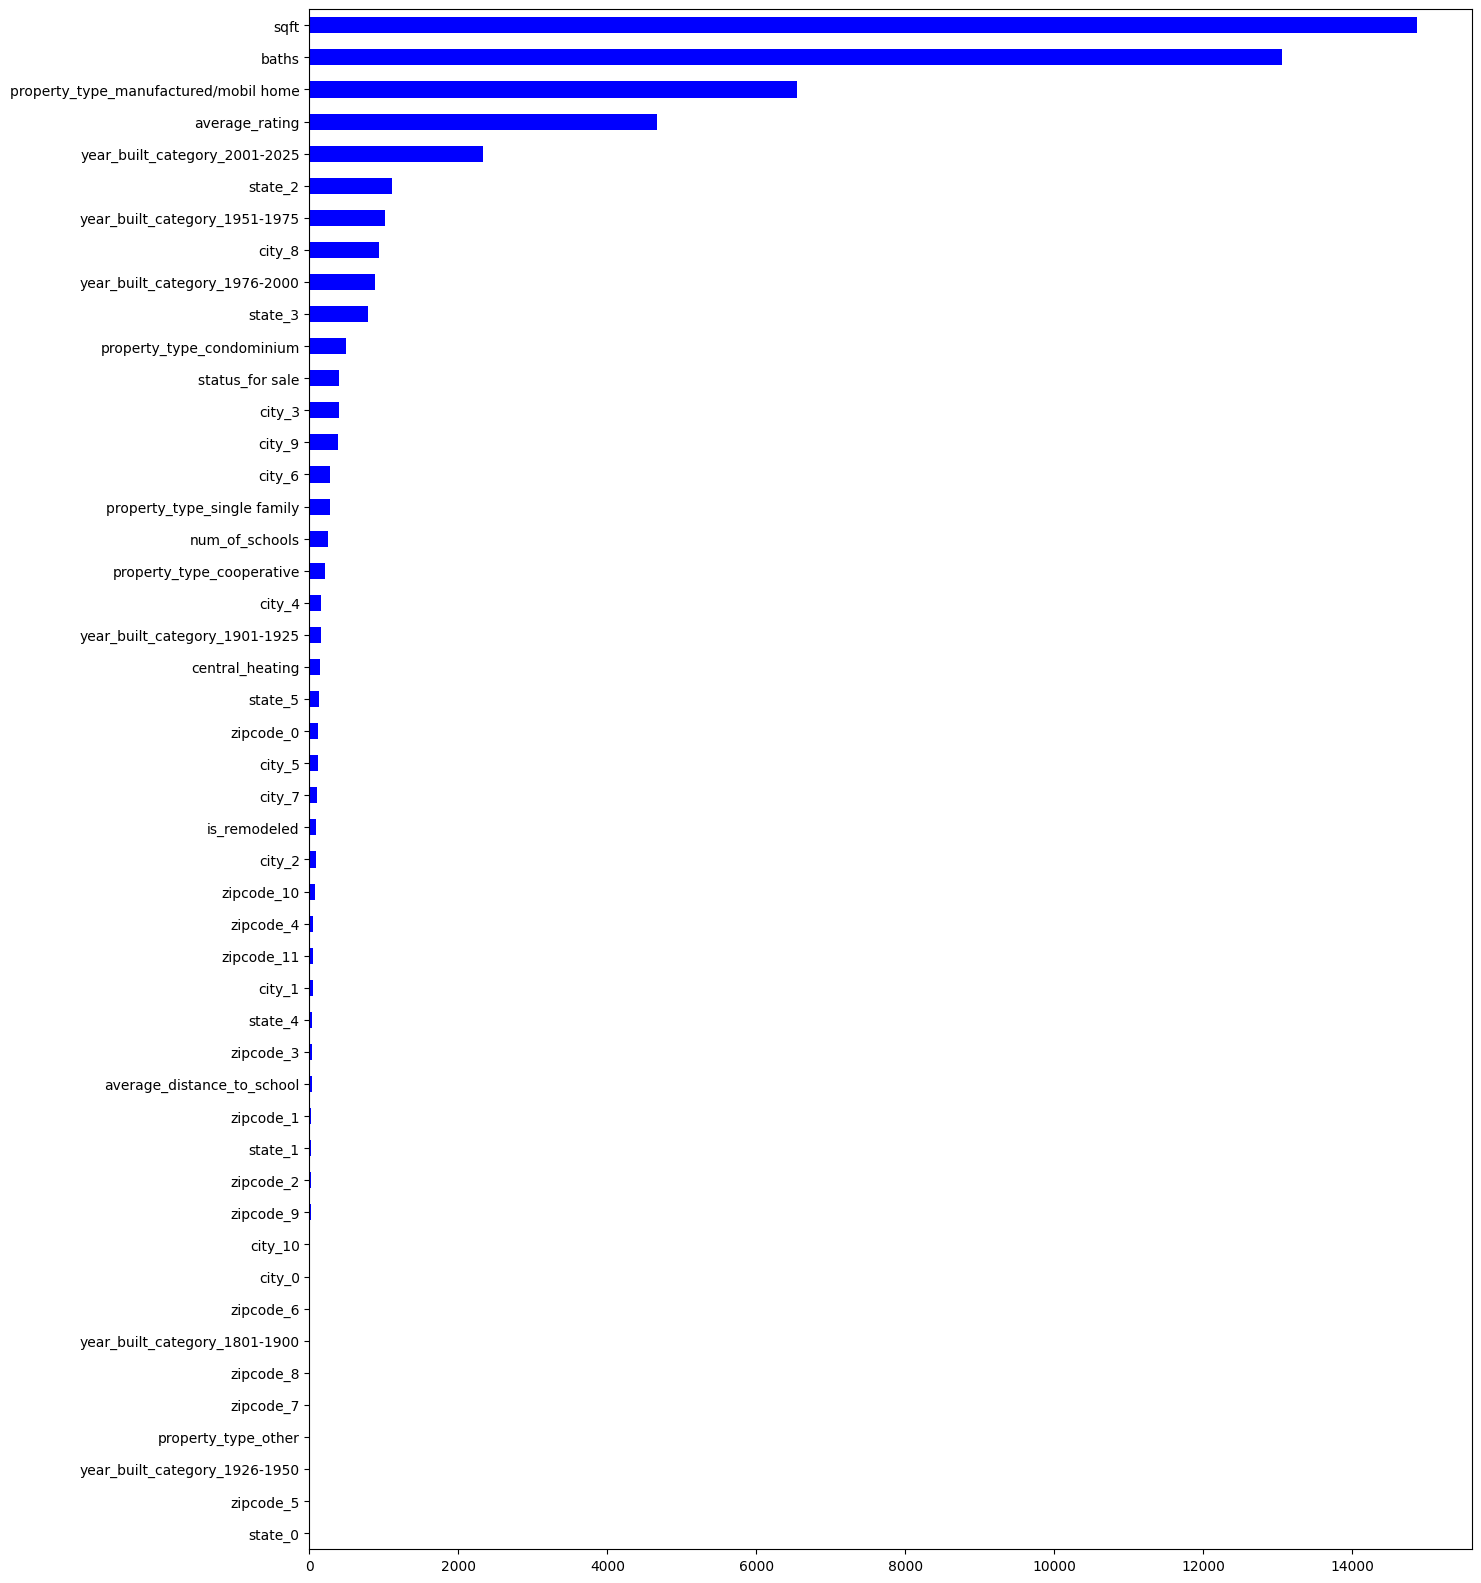

In [27]:
# Визуализируем результат анализа значимости:
imp_num = pd.Series(feature_selection.f_regression(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='b');

С помощью SelectKBest отберём 40 признаков, наилучшим образом подходящих для предсказания целевой переменной. Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

> *На 40 признаках лучшая модель показала качество немного хуже, чем на всех признаках, поэтому в итоге на вход моделям подаются все признаки.*

In [28]:
selector = feature_selection.SelectKBest(
    feature_selection.f_regression, 
    k=48
)
selector.fit(X_train, y_train)
best_features = selector.get_feature_names_out()

X_train = X_train[best_features]
X_test = X_test[best_features]

# Посмотрим на размерности выборок
print(f'Размерность обучающей выборки {X_train.shape}')
print(f'Размерность тестовой выборки {X_test.shape}')

list(best_features)

Размерность обучающей выборки (85802, 48)
Размерность тестовой выборки (42261, 48)


['baths',
 'sqft',
 'is_remodeled',
 'num_of_schools',
 'average_rating',
 'average_distance_to_school',
 'central_heating',
 'property_type_condominium',
 'property_type_cooperative',
 'property_type_manufactured/mobil home',
 'property_type_other',
 'property_type_single family',
 'year_built_category_1801-1900',
 'year_built_category_1901-1925',
 'year_built_category_1926-1950',
 'year_built_category_1951-1975',
 'year_built_category_1976-2000',
 'year_built_category_2001-2025',
 'status_for sale',
 'city_0',
 'city_1',
 'city_2',
 'city_3',
 'city_4',
 'city_5',
 'city_6',
 'city_7',
 'city_8',
 'city_9',
 'city_10',
 'zipcode_0',
 'zipcode_1',
 'zipcode_2',
 'zipcode_3',
 'zipcode_4',
 'zipcode_5',
 'zipcode_6',
 'zipcode_7',
 'zipcode_8',
 'zipcode_9',
 'zipcode_10',
 'zipcode_11',
 'state_0',
 'state_1',
 'state_2',
 'state_3',
 'state_4',
 'state_5']

### 4.4 Масштабирование признаков

#### 4.4.1 Нормализация признаков

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, необходимо масштабировать признаки. Распределения признаков - отличное от нормального. Несмотря на то, что данные прошли очистку, всё же распределения количественных признаков имеют явное правостороннее смещение. RobustScaler в вычислении использует перцентили, и поэтому не зависит даже от большого количества выбросов, выберем этот способ нормализации данных.

In [29]:
# Инициализируем нормализатор RobustScaler
scaler = preprocessing.RobustScaler()
scaler.fit(X_train[num_cols]) # fit() только на train данных
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = scaler.transform(X_train[num_cols]) # fransform() на train данных
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols]) # fransform() на test/valid данных

In [30]:
data_train_scaled = pd.DataFrame(X_train_scaled, columns=best_features)
data_train_scaled.head()

baths      sqft  is_remodeled  num_of_schools  average_rating  \
115487    2.5  2.099138             0             5.0             1.5   
67576     0.0 -0.079741             1             3.0             0.5   
111432    0.0  0.099138             0             4.0             0.5   
72050     0.0 -0.537716             0             5.0             0.0   
108254    0.0 -0.275862             1             0.0            -0.5   

        average_distance_to_school  central_heating  \
115487                         0.5                0   
67576                          3.5                1   
111432                         0.5                0   
72050                         -0.5                0   
108254                         1.5                0   

        property_type_condominium  property_type_cooperative  \
115487                        0.0                        0.0   
67576                         1.0                        0.0   
111432                        0.0                        0.0   
72050                         0.0                        0.0   
108254                        0.0                        0.0   

        property_type_manufactured/mobil home  ...  zipcode_8  zipcode_9  \
115487                                    0.0  ...          0          0   
67576                                     0.0  ...          0          1   
111432                                    0.0  ...          0          0   
72050                                     0.0  ...          1          0   
108254                                    1.0  ...          0          0   

        zipcode_10  zipcode_11  state_0  state_1  state_2  state_3  state_4  \
115487           1           0        0        0        0        0        0   
67576            1           0        0        0        0        1        1   
111432           1           1        0        0        0        1        1   
72050            0           1        0        0        0        1        1   
108254           1           1        0        0        0        1        1   

        state_5  
115487        1  
67576         1  
111432        1  
72050         1  
108254        1  

[5 rows x 48 columns]

Посмотрим, удалось ли нормализовать числовые признаки.
Проверим гипотезу на нормальность данных с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

Признак baths
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак sqft
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак num_of_schools
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак average_rating
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак average_distance_to_school
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.



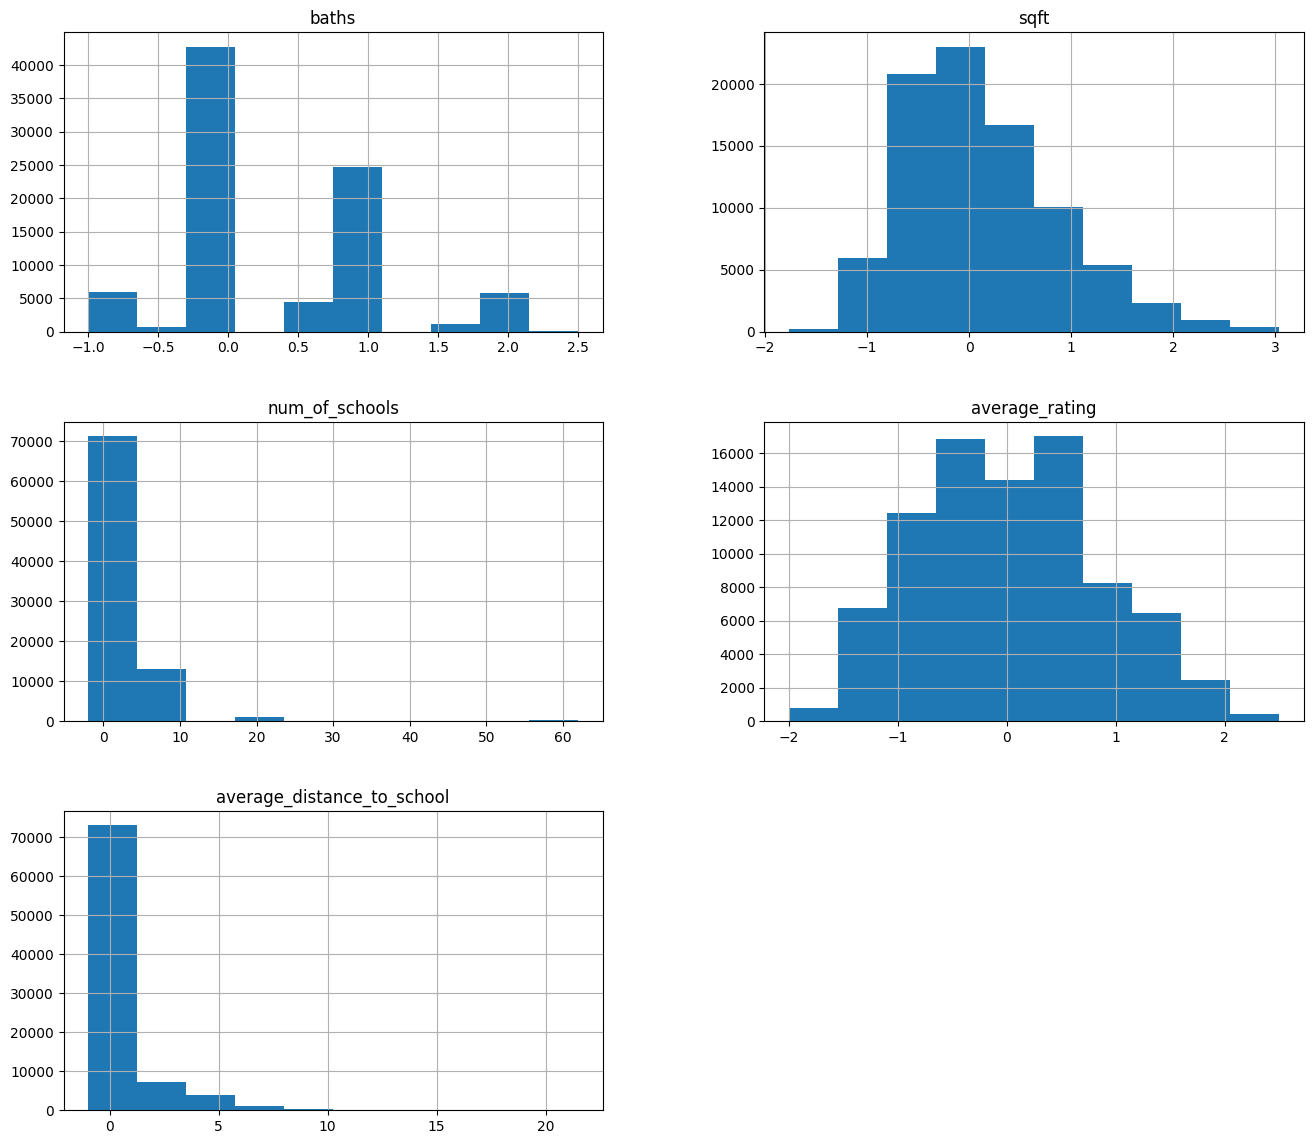

In [31]:
data_train_scaled[num_cols].hist(figsize=(16,14));

# Cформулируем нулевую и альтернативную гипотезы
H0 = 'Данные распределены нормально.'
Ha = 'Данные не распределены нормально.'

# Выбираем уровень значимости
alpha = 0.05
for col in num_cols:
    _, p_value = stats.normaltest(data_train_scaled[col]) # normaltest возвращает двустороннюю вероятность для проверки гипотезы
    print(f"Признак {col}")
    # Интерпретация
    if p_value > alpha/2:
        print(f"p_value: {round(p_value, 2)} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}\n")
    else:
        print(f"p_value: {round(p_value, 2)} <= {alpha}. Мы отвергаем нулевую гипотезу. {Ha}\n") 

#### 4.4.2 Логарифмирование признаков

Проведём также для сравнения логарифмирование числовых признаков и посмотрим на итоговое распределение. Также проверим, удалось ли нормализовать числовые признаки.
Проверим гипотезу на нормальность данных с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

In [32]:
X_train_log = X_train.copy()
X_test_log = X_test.copy()

# Логарифмирование
for col in num_cols:
#for col in ['baths', 'sqft', 'num_of_schools', 'average_rating']:
    X_train_log[col] = np.log(X_train_log[col] + 1)
    X_test_log[col] = np.log(X_test_log[col] + 1)
    
X_train_log.head()

baths      sqft  is_remodeled  num_of_schools  average_rating  \
115487  1.704748  8.209852             0        2.197266        2.197266   
67576   1.098612  7.411556             1        1.946289        1.946289   
111432  1.098612  7.507141             0        2.080078        1.946289   
72050   1.098612  7.114769             0        2.197266        1.791992   
108254  1.098612  7.295056             1        1.386719        1.609375   

        average_distance_to_school  central_heating  \
115487                    1.386719                0   
67576                     2.302734                1   
111432                    1.386719                0   
72050                     0.693359                0   
108254                    1.791992                0   

        property_type_condominium  property_type_cooperative  \
115487                        0.0                        0.0   
67576                         1.0                        0.0   
111432                        0.0                        0.0   
72050                         0.0                        0.0   
108254                        0.0                        0.0   

        property_type_manufactured/mobil home  ...  zipcode_8  zipcode_9  \
115487                                    0.0  ...          0          0   
67576                                     0.0  ...          0          1   
111432                                    0.0  ...          0          0   
72050                                     0.0  ...          1          0   
108254                                    1.0  ...          0          0   

        zipcode_10  zipcode_11  state_0  state_1  state_2  state_3  state_4  \
115487           1           0        0        0        0        0        0   
67576            1           0        0        0        0        1        1   
111432           1           1        0        0        0        1        1   
72050            0           1        0        0        0        1        1   
108254           1           1        0        0        0        1        1   

        state_5  
115487        1  
67576         1  
111432        1  
72050         1  
108254        1  

[5 rows x 48 columns]

Признак baths
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак sqft
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак num_of_schools
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак average_rating
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.

Признак average_distance_to_school
p_value: 0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Данные не распределены нормально.



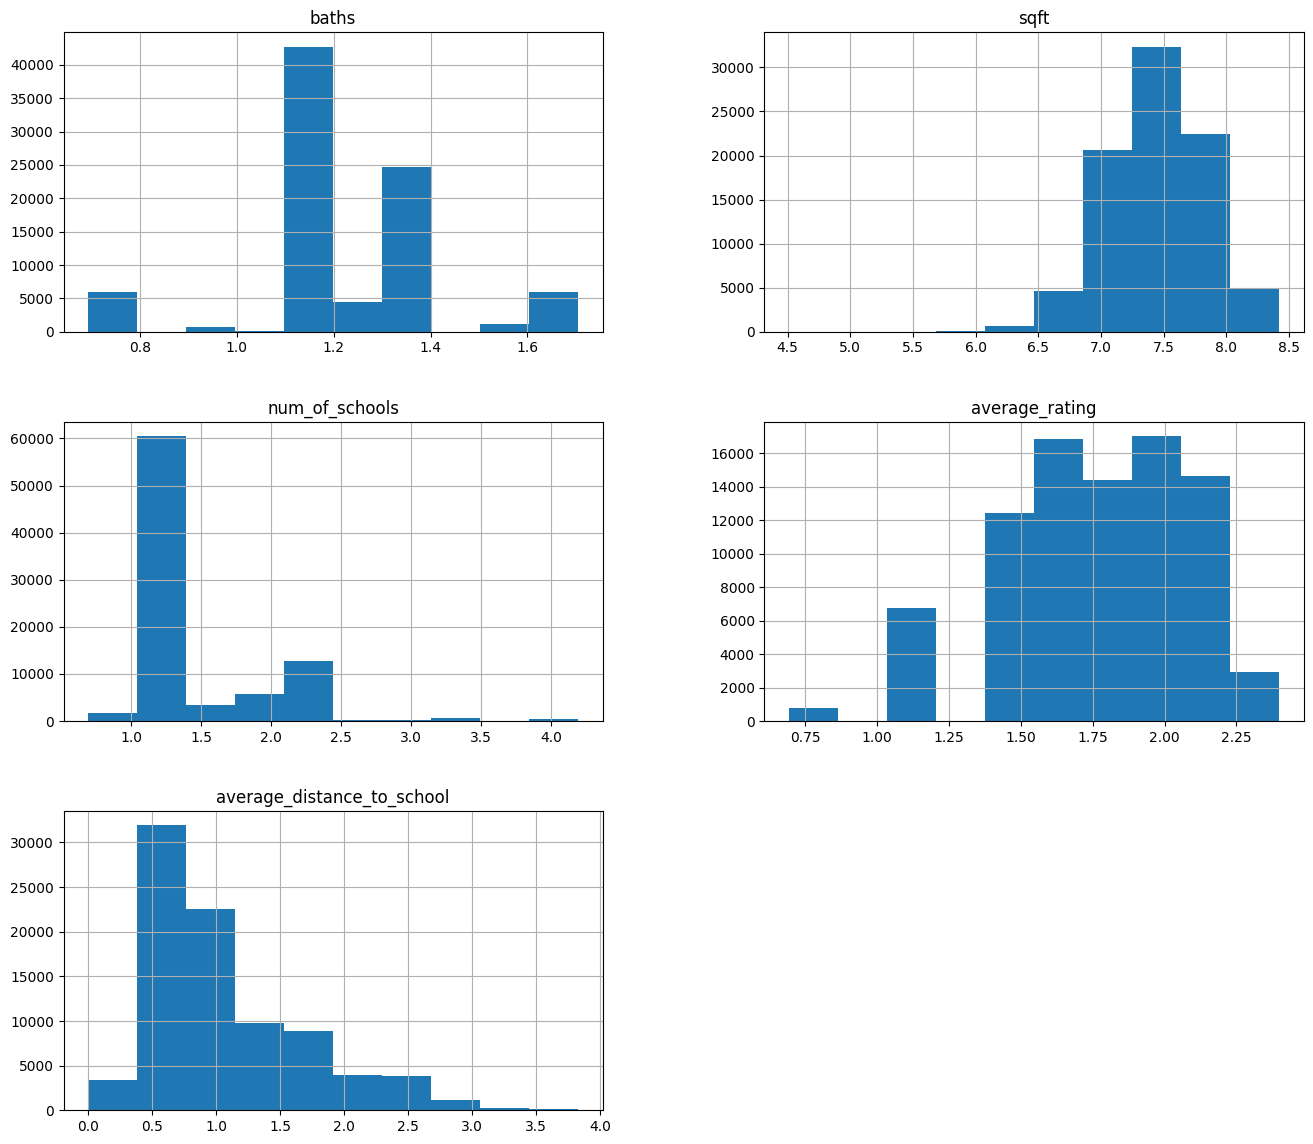

In [33]:
X_train_log[num_cols].hist(figsize=(16,14));

# Cформулируем нулевую и альтернативную гипотезы
H0 = 'Данные распределены нормально.'
Ha = 'Данные не распределены нормально.'

# Выбираем уровень значимости
alpha = 0.05
for col in num_cols:
    _, p_value = stats.normaltest(X_train_log[col]) # normaltest возвращает двустороннюю вероятность для проверки гипотезы
    print(f"Признак {col}")
    # Интерпретация
    if p_value > alpha/2:
        print(f"p_value: {round(p_value, 2)} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}\n")
    else:
        print(f"p_value: {round(p_value, 2)} <= {alpha}. Мы отвергаем нулевую гипотезу. {Ha}\n") 

> *Нормализация и логарифмирование не справились с нормализацией распределения данных. B любом случае, решена задача масштабирования. Для решения задачи регрессии будем использовать шкалированные данные, а для лучшей модели применим шкалированные и логарифмированные данные и сравним результаты.*

___

## 5. Решение задачи регрессии: линейная регрессия

Воспользуемся функцией, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка в долларах;
2. MAPE - средняя абсолютная ошибка в процентах;
3. $R^2$ - коэффициент детерминации.

### 5.1 Линейная регрессия (базовая модель)

In [34]:
# Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()

# Обучаем модель
lr.fit(X_train_scaled, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

# Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.288
Train MAE: 75255
Train MAPE: 29.74


Test R^2: 0.290
Test MAE: 75309
Test MAPE: 29.68


### 5.2 Модель полиномиальной регрессии 2-ой степени

In [35]:
# Создаем объект для генерации полиномиальных признаков степени 2 
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

# Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_test_scaled_poly = poly.fit_transform(X_test_scaled)

# Посмотрим на результирующее число признаков
print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Valid shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (85802, 1224)
Valid shape: (42261, 1224)


In [36]:
lr_poly = linear_model.LinearRegression()

# Обучим модель линейной регрессии на полиномиальных признаках
lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)

# Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.550
Train MAE: 58010
Train MAPE: 22.27


Test R^2: -131980880449705.656
Test MAE: 10859575384
Test MAPE: 4030008.14


### 5.3 Модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову)

In [37]:
# Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge(alpha=0.1)

# Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred = ridge_lr_poly.predict(X_test_scaled_poly)

# Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.550
Train MAE: 58012
Train MAPE: 22.27


Test R^2: 0.539
Test MAE: 58713
Test MAPE: 22.53


### 5.4 Модель полиномиальной регрессии с L1-регуляризацией

In [38]:
# # Создаём объект класса линейной регрессии с L1-регуляризацией
# lasso_lr_poly = linear_model.Lasso(alpha=0.5, max_iter=2000)
# # Обучаем модель 
# lasso_lr_poly.fit(X_train_scaled_poly, y_train)

# # Делаем предсказание для каждой из выборок
# y_train_pred = lasso_lr_poly.predict(X_train_scaled_poly)
# y_test_pred = lasso_lr_poly.predict(X_test_scaled_poly)

# # Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
# print_metrics(y_train, y_train_pred, y_test, y_test_pred)

> *Базовая модель не справилась с задачей. Линейная регрессия на полиномиальных признаках показала переобучение. Применение L2-регуляризации дало более удовлетворительные результаты. Модель полиномиальной регрессии с L1-регуляризацией не улучшила результаты предыдущей модели и достаточно долго обучалась, поэтому результаты ее работы здесь не приводятся.*

___

## 6. Решение задачи регрессии: дерево решений

### 6.1 Модель модель дерева решений с параметрами по умолчанию

In [39]:
# Создаём объект класса DecisionTreeRegressor
dt = tree.DecisionTreeRegressor(random_state=17)
# Обучаем модель
dt.fit(X_train_scaled, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

# Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.997
Train MAE: 980
Train MAPE: 0.33


Test R^2: 0.425
Test MAE: 56817
Test MAPE: 21.09


### 6.2 Модель модель дерева решений с параметрами, подобранными по сетке

In [40]:
param_grid = {'max_depth': list(range(7, 20))}
            
grid_search_tree = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(random_state=17), 
    param_grid=param_grid,
    n_jobs = -1
)
# Обучаем модель  
grid_search_tree.fit(X_train_scaled, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = grid_search_tree.predict(X_train_scaled)
y_test_pred = grid_search_tree.predict(X_test_scaled)

# Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

grid_search_tree.best_params_

Train R^2: 0.687
Train MAE: 44956
Train MAPE: 17.00


Test R^2: 0.467
Test MAE: 59686
Test MAPE: 22.60


{'max_depth': 14}

> *Дерево решений с параметрами по умолчанию дало отличный результат на тренировочном наборе, но гораздо худший - на тестовом, что означает, что модель переобучилась. Подбор гиперпараметров справился с переобучением, но всё же метрики оказались хуже, чем у модели линейной регрессии с L2-регуляризацией.*

___

## 7. Решение задачи регрессии: ансамблевые методы

### 7.1 Модель случайного леса

In [41]:
# Создаём объект RandomForestRegressor
rf = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=17,
    verbose=True,
    n_jobs=-1
    )

# Обучаем модель  
rf.fit(X_train_scaled, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

# Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   32.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Train R^2: 0.621
Train MAE: 53642
Train MAPE: 20.78


Test R^2: 0.557
Test MAE: 57761
Test MAPE: 22.36


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


### 7.2 Модель случайного леса с параметрами, подобранными с помощью OPTUNA

In [42]:
# зафиксируем random_state
random_state = 17

In [43]:
# def optuna_rf(trial):
#   # задаем пространства поиска гиперпараметров
#   n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
#   max_depth = trial.suggest_int('max_depth', 10, 30, 1)
#   min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

#   # создаем модель
#   model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
#                                           max_depth=max_depth,
#                                           min_samples_leaf=min_samples_leaf,
#                                           random_state=random_state)
#   # обучаем модель
#   model.fit(X_train_scaled, y_train)
#   score = metrics.mean_absolute_percentage_error(y_train, model.predict(X_train_scaled))

#   return score

# # cоздаем объект исследования
# # можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
# study = optuna.create_study(study_name='RandomForestRegressor', direction='minimize')
# # ищем лучшую комбинацию гиперпараметров n_trials раз
# study.optimize(optuna_rf, n_trials=20)

# # выводим результаты на обучающей выборке
# print("Наилучшие значения гиперпараметров {}".format(study.best_params))
# print("MAPE на обучающем наборе: {:.2f}".format(study.best_value))

# # рассчитаем точность для тестовой выборки
# model = ensemble.RandomForestRegressor(**study.best_params,random_state=random_state, )
# model.fit(X_train_scaled, y_train)
# y_train_pred = model.predict(X_train_scaled)

# # Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
# print_metrics(y_train, y_train_pred, y_test, y_test_pred)

> *Модель случайного леса с гиперпараметрами, подобранными при помощи метода оптимизации OPTUNA, на тесте показала тот же результат, что и предыдущая модель случайного леса, а на обучающих данных - более высокое качество, что свидетельствует о переобучении. Пока лучшие результаты у модели случайного леса с параметрами подобранными вручную (Test R2: 0.557, MAE: 57761, MAPE: 22.36).*

### 7.3 Модель градиентного бустинга над деревьями решений

#### 7.3.1 Модель градиентного бустинга над деревьями решений

In [44]:
# Создаём объект GradientBoostingRegressor
gb = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=17,
    verbose=True
    )

# Обучаем модель  
gb.fit(X_train_scaled, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)

# Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

      Iter       Train Loss   Remaining Time 


         1 10182540173.1763           47.23s
         2  9054603636.1192           43.13s
         3  8325273592.9337           40.58s
         4  7803380207.4746           38.67s
         5  7374769980.3587           37.46s
         6  7161047882.0790           36.28s
         7  6882815864.2554           35.78s
         8  6679186221.6886           34.95s
         9  6581456623.2111           34.15s
        10  6291963086.0737           33.54s
        20  5389261567.8605           29.92s
        30  4812301744.9701           26.06s
        40  4440563207.1650           22.32s
        50  4169587645.7196           18.65s
        60  3955438164.2228           14.83s
        70  3781850199.8372           11.13s
        80  3575016320.6560            7.41s
        90  3442716507.8102            3.70s
       100  3337372878.3571            0.00s
Train R^2: 0.736
Train MAE: 43634
Train MAPE: 16.58


Test R^2: 0.659
Test MAE: 49268
Test MAPE: 18.72


#### 7.3.2 Модель градиентного бустинга над деревьями решений (логарифмированные данные)

In [45]:
# Создаём объект GradientBoostingRegressor
gbl = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=17,
    verbose=True
    )

# Обучаем модель  
gbl.fit(X_train_log, y_train)

# Делаем предсказание для каждой из выборок
y_train_log_pred = gbl.predict(X_train_log)
y_test_log_pred = gbl.predict(X_test_log)

# Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
print_metrics(y_train, y_train_log_pred, y_test, y_test_log_pred)

      Iter       Train Loss   Remaining Time 
         1 10182540173.1763           44.48s
         2  9054603636.1192           41.04s
         3  8325273592.9337           38.50s
         4  7803380207.4746           37.15s
         5  7374769980.3587           36.35s
         6  7161047882.0790           35.48s
         7  6882815864.2554           35.20s
         8  6679186221.6886           34.56s
         9  6581456623.2111           33.96s
        10  6291963086.0737           33.66s
        20  5389261567.8605           29.74s
        30  4812301744.9701           26.34s
        40  4440563207.1650           22.43s
        50  4169587645.7196           18.62s
        60  3955438164.2228           14.84s
        70  3781850199.8372           11.11s
        80  3575016320.6560            7.39s
        90  3442716507.8102            3.67s
       100  3337372878.3571            0.00s
Train R^2: 0.736
Train MAE: 43634
Train MAPE: 16.58


Test R^2: 0.659
Test MAE: 49276
Test MAPE: 18

> *Модель градиентного бустинга с параметрами подобраными вручную показавает лучшее качество, как на шкалированных, так и на логарифмированных признаках, на первых - качество незначительно выше: Тest R2: 0.659, MAE: 49268, MAPE: 18.72. Попробуем подобрать гиперпараметры и улучшить результаты.*

### 7.4 Модель градиентного бустинга над деревьями решений с параметрами, подобранными с помощью OPTUNA

In [ ]:
def optuna_gb(trial):
  # Задаем пространства поиска гиперпараметров
  learning_rate = trial.suggest_float('learning_rate', 0.1, 0.5, step=0.1)
  n_estimators = trial.suggest_int('n_estimators', 80, 300, 1)
  max_depth = trial.suggest_int('max_depth', 2, 5, 1)
  #min_samples_split = trial.suggest_int('min_samples_split', 20, 40, 1)
  
  # Создаем модель
  model = ensemble.GradientBoostingRegressor(learning_rate=learning_rate,
                                         n_estimators=n_estimators,
                                         max_depth=max_depth,
                                         #min_samples_split=min_samples_split,
                                         random_state=random_state)
  # Обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.mean_absolute_percentage_error(y_train, model.predict(X_train_scaled))

  return score

# Создаем объект исследования
# Можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name='GradientBoostingRegressor', direction='minimize')
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=20)

# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.2f}".format(study.best_value))

# Рассчитаем точность для тестовой выборки
model = ensemble.GradientBoostingRegressor(**study.best_params,random_state=random_state)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

# Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

[I 2023-11-04 15:32:36,781] A new study created in memory with name: GradientBoostingRegressor
[I 2023-11-04 15:33:28,562] Trial 0 finished with value: 0.19014929517236565 and parameters: {'learning_rate': 0.30000000000000004, 'n_estimators': 205, 'max_depth': 4}. Best is trial 0 with value: 0.19014929517236565.
[I 2023-11-04 15:33:43,286] Trial 1 finished with value: 0.25527530903571777 and parameters: {'learning_rate': 0.2, 'n_estimators': 117, 'max_depth': 2}. Best is trial 0 with value: 0.19014929517236565.
[I 2023-11-04 15:34:55,100] Trial 2 finished with value: 0.16294030471544224 and parameters: {'learning_rate': 0.4, 'n_estimators': 230, 'max_depth': 5}. Best is trial 2 with value: 0.16294030471544224.
[I 2023-11-04 15:35:18,320] Trial 3 finished with value: 0.2466005402169358 and parameters: {'learning_rate': 0.4, 'n_estimators': 188, 'max_depth': 2}. Best is trial 2 with value: 0.16294030471544224.
[I 2023-11-04 15:36:13,022] Trial 4 finished with value: 0.1880904516491887 an

Наилучшие значения гиперпараметров {'learning_rate': 0.4, 'n_estimators': 300, 'max_depth': 5}
MAPE на обучающем наборе: 0.15
Train R^2: 0.753
Train MAE: 42200
Train MAPE: 16.02


Test R^2: 0.659
Test MAE: 49268
Test MAPE: 18.72


Качество на тесте не улучшилось, но модель начала переобучаться.

In [ ]:
optuna.visualization.plot_optimization_history(study, target_name="mean_absolute_percentage_error")

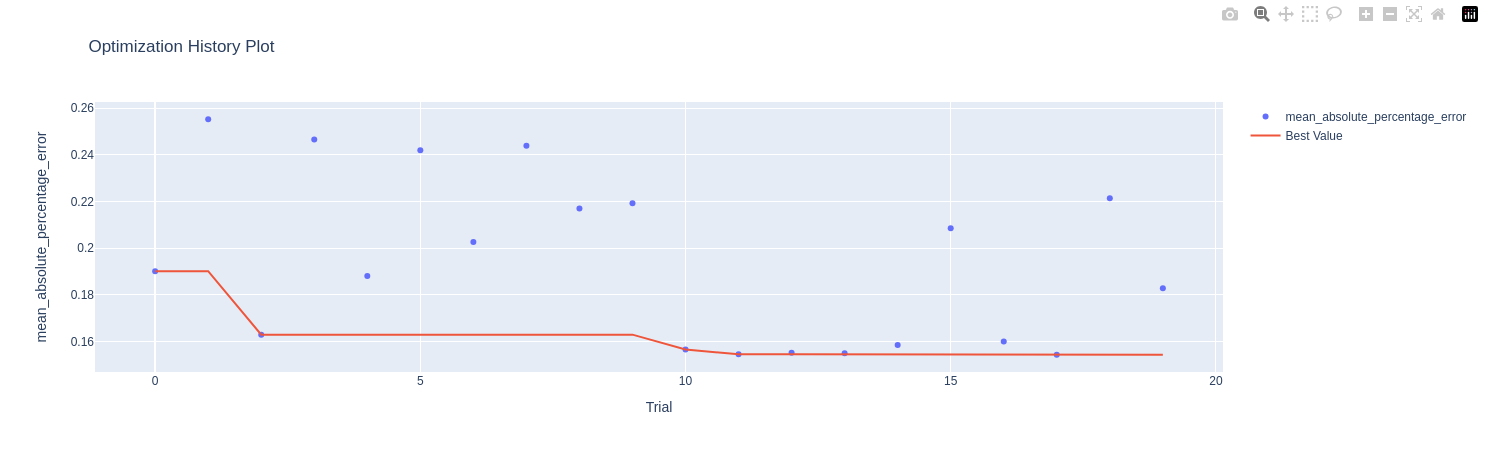

Посмотрим, на какой гиперпараметр стоит обратить внимание.

In [ ]:
optuna.visualization.plot_param_importances(study, target_name="mean_absolute_percentage_error")

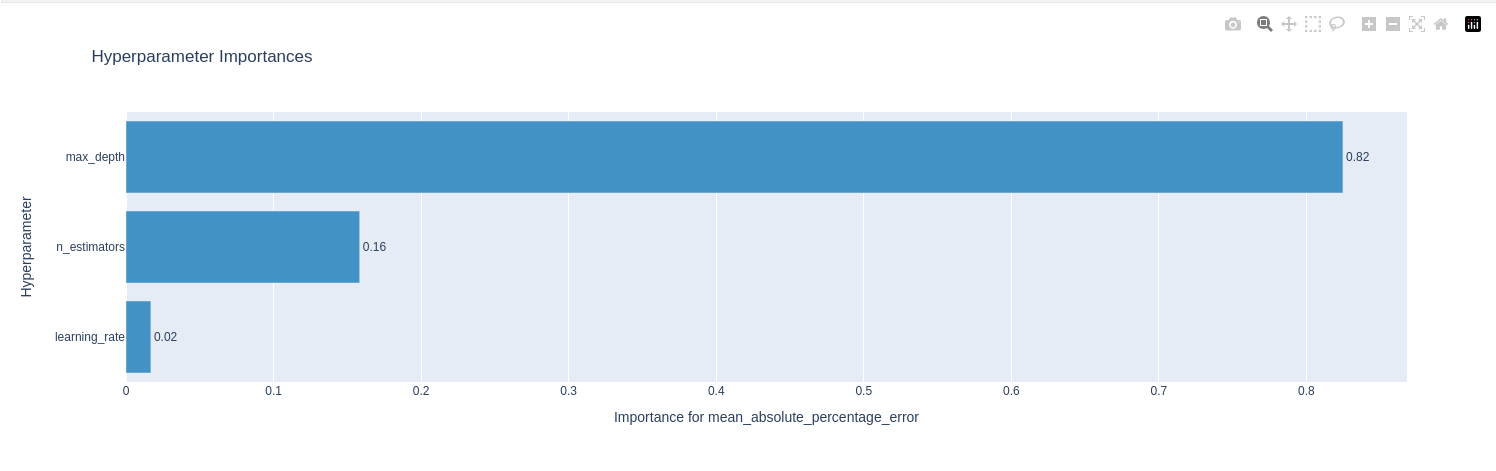

Немного изменим диапазон для max_depth, и увеличим количество деревьев, хотя, вероятно, это может привести к переобучению.

In [ ]:
def optuna_gb(trial):
  # Задаем пространства поиска гиперпараметров
  learning_rate = trial.suggest_float('learning_rate', 0.4, 0.5, step=0.1)
  n_estimators = trial.suggest_int('n_estimators', 275, 400, 1)
  max_depth = trial.suggest_int('max_depth', 1, 6, 1)
  #min_samples_split = trial.suggest_int('min_samples_split', 20, 40, 1)
  
  # Создаем модель
  model = ensemble.GradientBoostingRegressor(learning_rate=learning_rate,
                                         n_estimators=n_estimators,
                                         max_depth=max_depth,
                                         #min_samples_split=min_samples_split,
                                         random_state=random_state)
  # Обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.mean_absolute_percentage_error(y_train, model.predict(X_train_scaled))

  return score

# Создаем объект исследования
# Можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name='GradientBoostingRegressor', direction='minimize')
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=50)

# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.2f}".format(study.best_value))

# Рассчитаем точность для тестовой выборки
model = ensemble.GradientBoostingRegressor(**study.best_params,random_state=random_state)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

# Для полученной модели рассчитаем метрики на тренировочной и тестовой выборках
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

[I 2023-11-04 17:03:56,698] A new study created in memory with name: GradientBoostingRegressor
[I 2023-11-04 17:04:41,552] Trial 0 finished with value: 0.23687069785919007 and parameters: {'learning_rate': 0.5, 'n_estimators': 338, 'max_depth': 2}. Best is trial 0 with value: 0.23687069785919007.
[I 2023-11-04 17:06:52,063] Trial 1 finished with value: 0.1277138829439851 and parameters: {'learning_rate': 0.4, 'n_estimators': 346, 'max_depth': 6}. Best is trial 1 with value: 0.1277138829439851.
[I 2023-11-04 17:07:33,942] Trial 2 finished with value: 0.2363804832755025 and parameters: {'learning_rate': 0.5, 'n_estimators': 349, 'max_depth': 2}. Best is trial 1 with value: 0.1277138829439851.
[I 2023-11-04 17:09:02,120] Trial 3 finished with value: 0.16174379741396447 and parameters: {'learning_rate': 0.4, 'n_estimators': 284, 'max_depth': 5}. Best is trial 1 with value: 0.1277138829439851.
[I 2023-11-04 17:10:09,021] Trial 4 finished with value: 0.20347239791733668 and parameters: {'lea

Наилучшие значения гиперпараметров {'learning_rate': 0.4, 'n_estimators': 400, 'max_depth': 6}
MAPE на обучающем наборе: 0.12
Train R^2: 0.852
Train MAE: 32292
Train MAPE: 12.23


Test R^2: 0.659
Test MAE: 49268
Test MAPE: 18.72


Так и есть, модель переобучилось, а качество на тесте всё то же.

Выведем таблицу с результатами работы всех моделей.

In [47]:
# Составим таблицу из полученных результатов 
result_data = pd.DataFrame({'model': ['LinearRegression(baseline)', 'LinearRegression', 'Ridge', 'DecisionTreeRegressor', 'DecisionTreeRegressor',
                                      'RandomForestRegressor', 'GradientBoostingRegressor', 'GradientBoostingRegressor',
                                      'GradientBoostingRegressor', 'GradientBoostingRegressor'],
                            'Parameters': ['default', 'default', 'alpha=0.1', 'random_state=17', 'max_depth: 14', 
                                           'n_estimators=200, max_depth=12, criterion="squared_error", min_samples_split=20, random_state=17', 
                                           'learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=30, random_state=17',
                                           'learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=30, random_state=17',
                                           'learning_rate=0.4, n_estimators=300, max_depth=5',
                                           'learning_rate=0.4, n_estimators=400, max_depth=6'],
                            'RobustScaler': [True, True, True, True, True, True, True, False, True, True],
                            'LogFeatures': [False, False, False, False, False, False, False, True, False, False], 
                            'PolynomialFeatures': [False, True, True, False, False, False, False, False, False, False], 
                            'R2_train': [0.288, 0.550, 0.550, 0.997, 0.687, 0.621, 0.736, 0.736, 0.753, 0.852],
                            'R2_test': [0.290, -1, 0.539, 0.425, 0.467, 0.557, 0.659, 0.659, 0.659, 0.659],
                            'MAE_train': [75255, 58010, 58012, 980, 44956, 53642, 43634, 43634, 42200, 32292], 
                            'MAE_test': [75309, 2046670641, 58713, 56817, 59686, 57761, 49268, 49276, 49268, 49268],
                            'MAPE_train': [29.74, 22.27, 22.27, 0.33, 17.00, 20.78, 16.58, 16.58, 16.02, 12.23], 
                            'MAPE_test': [29.68, 708094.75, 22.53, 21.09, 22.60, 22.36, 18.72, 18.72, 18.72, 18.72]
                            })
display(result_data)
# Посмотрим лучший результат по метрикe MAPE на тестовых данных:
print("\nЛучший результат по метрикe MAPE на тестовых данных:")
display(result_data[result_data['MAPE_test'] == result_data['MAPE_test'].min()])

# Посмотрим лучший результат по метрикe MAE на тестовых данных:
print("\nЛучший результат по метрикe MAE на тестовых данных:")
display(result_data[result_data['MAE_test'] == result_data['MAE_test'].min()])

# Посмотрим лучший результат по метрикe R2 на валидационных фолдах:
print("\nЛучший результат по метрикe R2 на тестовых данных:")
result_data[result_data['R2_test'] == result_data['R2_test'].max()]

model  \
0  LinearRegression(baseline)   
1            LinearRegression   
2                       Ridge   
3       DecisionTreeRegressor   
4       DecisionTreeRegressor   
5       RandomForestRegressor   
6   GradientBoostingRegressor   
7   GradientBoostingRegressor   
8   GradientBoostingRegressor   
9   GradientBoostingRegressor   

                                          Parameters  RobustScaler  \
0                                            default          True   
1                                            default          True   
2                                          alpha=0.1          True   
3                                    random_state=17          True   
4                                      max_depth: 14          True   
5  n_estimators=200, max_depth=12, criterion="squ...          True   
6  learning_rate=0.5, n_estimators=100, max_depth...          True   
7  learning_rate=0.5, n_estimators=100, max_depth...         False   
8   learning_rate=0.4, n_estimators=300, max_depth=5          True   
9   learning_rate=0.4, n_estimators=400, max_depth=6          True   

   LogFeatures  PolynomialFeatures  R2_train  R2_test  MAE_train    MAE_test  \
0        False               False     0.288    0.290      75255       75309   
1        False                True     0.550   -1.000      58010  2046670641   
2        False                True     0.550    0.539      58012       58713   
3        False               False     0.997    0.425        980       56817   
4        False               False     0.687    0.467      44956       59686   
5        False               False     0.621    0.557      53642       57761   
6        False               False     0.736    0.659      43634       49268   
7         True               False     0.736    0.659      43634       49276   
8        False               False     0.753    0.659      42200       49268   
9        False               False     0.852    0.659      32292       49268   

   MAPE_train  MAPE_test  
0       29.74      29.68  
1       22.27  708094.75  
2       22.27      22.53  
3        0.33      21.09  
4       17.00      22.60  
5       20.78      22.36  
6       16.58      18.72  
7       16.58      18.72  
8       16.02      18.72  
9       12.23      18.72


Лучший результат по метрикe MAPE на тестовых данных:


model  \
6  GradientBoostingRegressor   
7  GradientBoostingRegressor   
8  GradientBoostingRegressor   
9  GradientBoostingRegressor   

                                          Parameters  RobustScaler  \
6  learning_rate=0.5, n_estimators=100, max_depth...          True   
7  learning_rate=0.5, n_estimators=100, max_depth...         False   
8   learning_rate=0.4, n_estimators=300, max_depth=5          True   
9   learning_rate=0.4, n_estimators=400, max_depth=6          True   

   LogFeatures  PolynomialFeatures  R2_train  R2_test  MAE_train  MAE_test  \
6        False               False     0.736    0.659      43634     49268   
7         True               False     0.736    0.659      43634     49276   
8        False               False     0.753    0.659      42200     49268   
9        False               False     0.852    0.659      32292     49268   

   MAPE_train  MAPE_test  
6       16.58      18.72  
7       16.58      18.72  
8       16.02      18.72  
9       12.23      18.72


Лучший результат по метрикe MAE на тестовых данных:


model  \
6  GradientBoostingRegressor   
8  GradientBoostingRegressor   
9  GradientBoostingRegressor   

                                          Parameters  RobustScaler  \
6  learning_rate=0.5, n_estimators=100, max_depth...          True   
8   learning_rate=0.4, n_estimators=300, max_depth=5          True   
9   learning_rate=0.4, n_estimators=400, max_depth=6          True   

   LogFeatures  PolynomialFeatures  R2_train  R2_test  MAE_train  MAE_test  \
6        False               False     0.736    0.659      43634     49268   
8        False               False     0.753    0.659      42200     49268   
9        False               False     0.852    0.659      32292     49268   

   MAPE_train  MAPE_test  
6       16.58      18.72  
8       16.02      18.72  
9       12.23      18.72


Лучший результат по метрикe R2 на тестовых данных:


model  \
6  GradientBoostingRegressor   
7  GradientBoostingRegressor   
8  GradientBoostingRegressor   
9  GradientBoostingRegressor   

                                          Parameters  RobustScaler  \
6  learning_rate=0.5, n_estimators=100, max_depth...          True   
7  learning_rate=0.5, n_estimators=100, max_depth...         False   
8   learning_rate=0.4, n_estimators=300, max_depth=5          True   
9   learning_rate=0.4, n_estimators=400, max_depth=6          True   

   LogFeatures  PolynomialFeatures  R2_train  R2_test  MAE_train  MAE_test  \
6        False               False     0.736    0.659      43634     49268   
7         True               False     0.736    0.659      43634     49276   
8        False               False     0.753    0.659      42200     49268   
9        False               False     0.852    0.659      32292     49268   

   MAPE_train  MAPE_test  
6       16.58      18.72  
7       16.58      18.72  
8       16.02      18.72  
9       12.23      18.72

> *Подбор гиперпараметров для модели градиентного бустинга над деревьями решений не принёс особых результатов, на тесте модели показали одинаковое качество, а на обучающей выборке, с ростом количества деревьев, модель стала сильнее переобучаться.*
>
> *В итоге лучшая модель - градиентный бустинг с гиперпараметрами: learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=30, random_state=17. Причём качество незначительно лучше на данных нормализованных посредством RobustScaler, чем на прологарифмированных.*


Выведем самые важные признаки для лучшей модели градиентного бустинга.

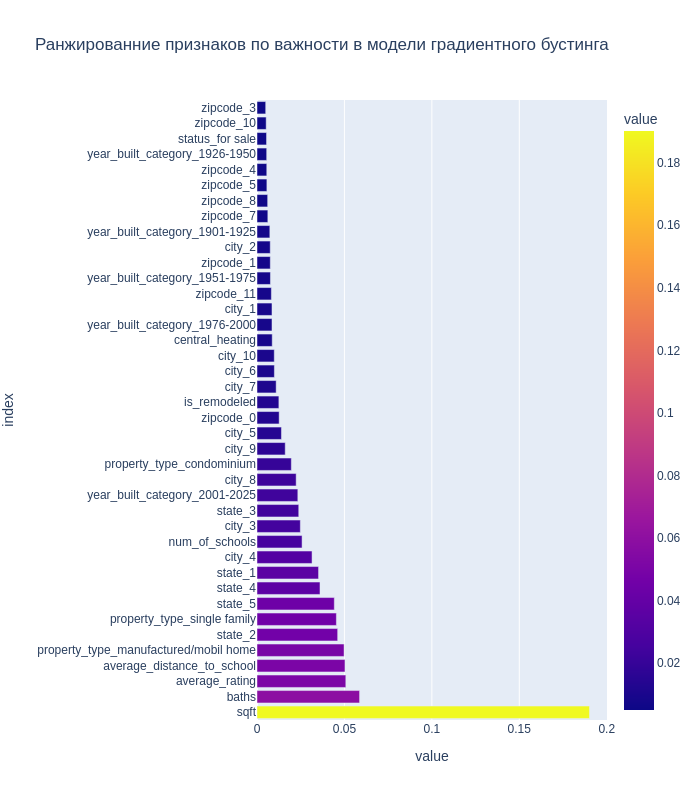

In [48]:
# Выведем самые важные признаки для градиентного бустинга
feature_importances = pd.Series(gb.feature_importances_, index=pd.DataFrame(X_train_scaled, columns=best_features).columns)
fig = px.bar(
    feature_importances.nlargest(40),
    color='value',
    height=800,
    title='Ранжированние признаков по важности в модели градиентного бустинга',
    orientation='h'
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_29.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

Также для сравнения приведу результаты лучшей модели на разных по числу наблюдений данных, где меняется диапазон целевой переменной и количество признаков.

**Количество наблюдений - 136271, количество признаков - 48, диапазон таргета - 30000-1129000$**

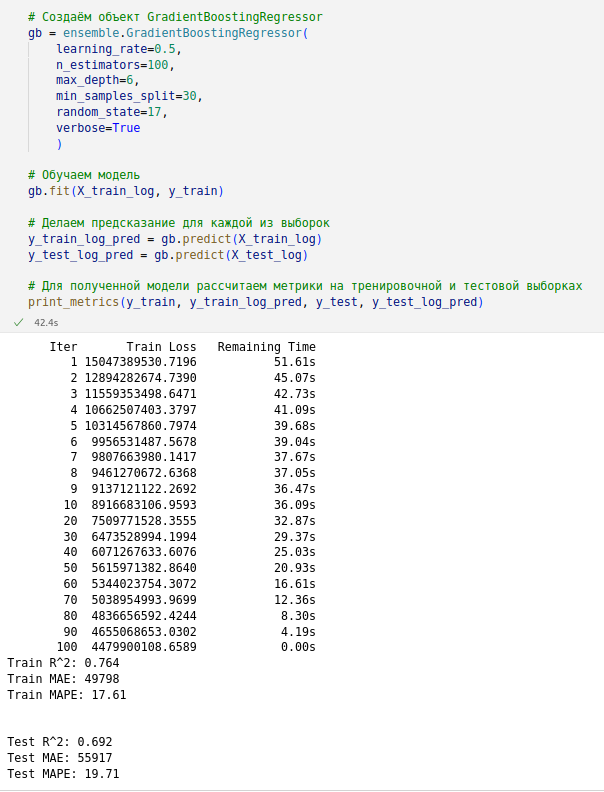

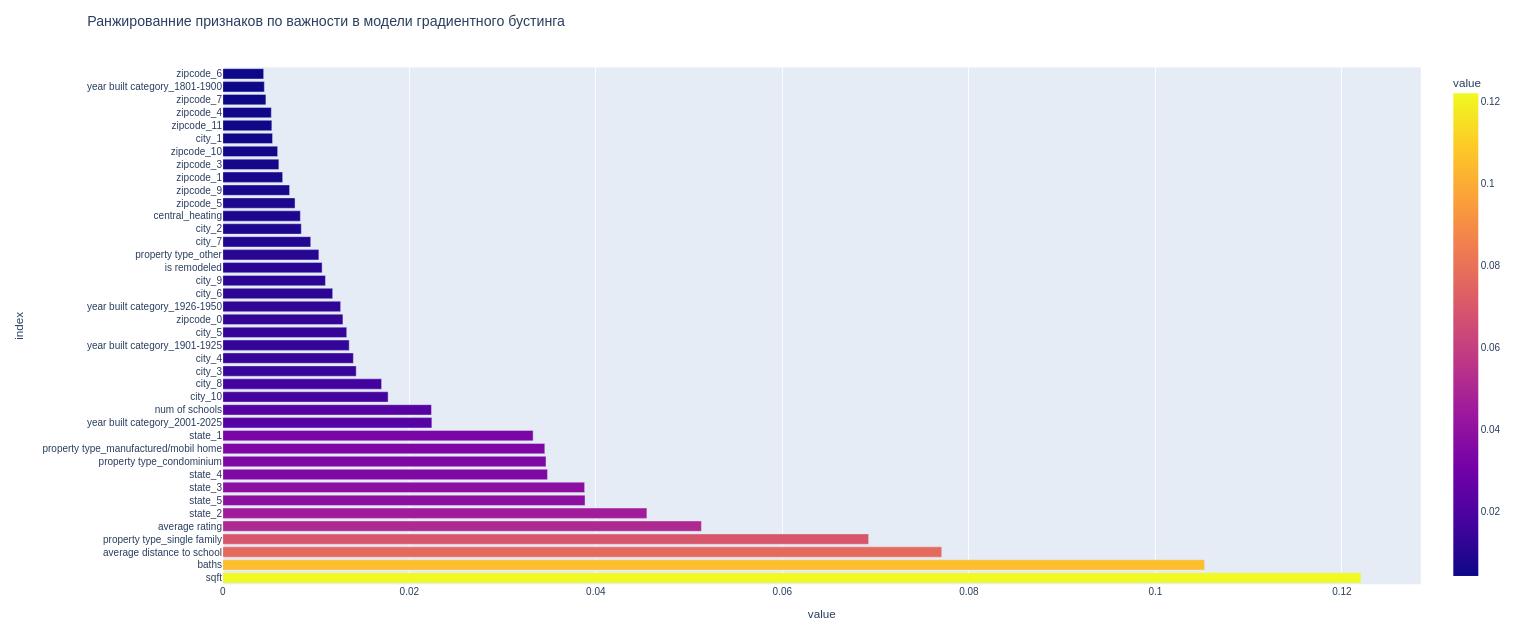

**Количество наблюдений - 133634, количество признаков - 48, диапазон таргета - 30000-975000$**

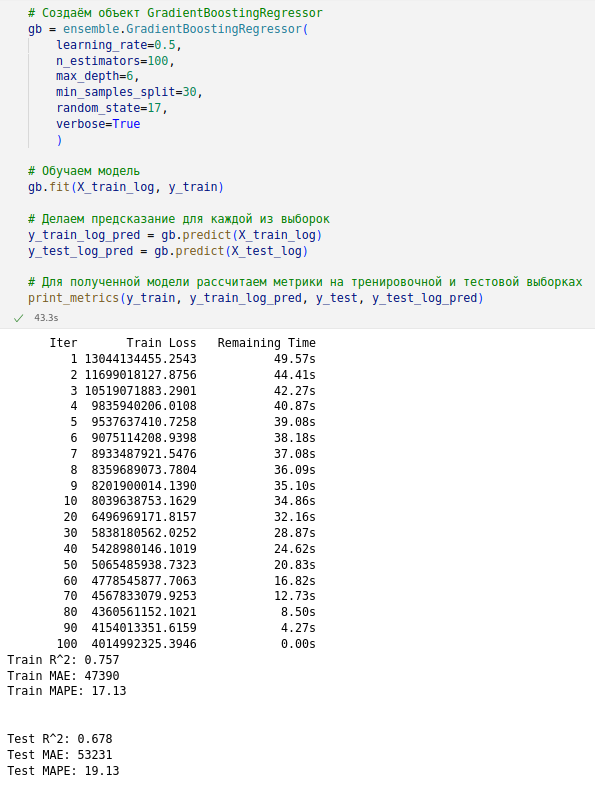

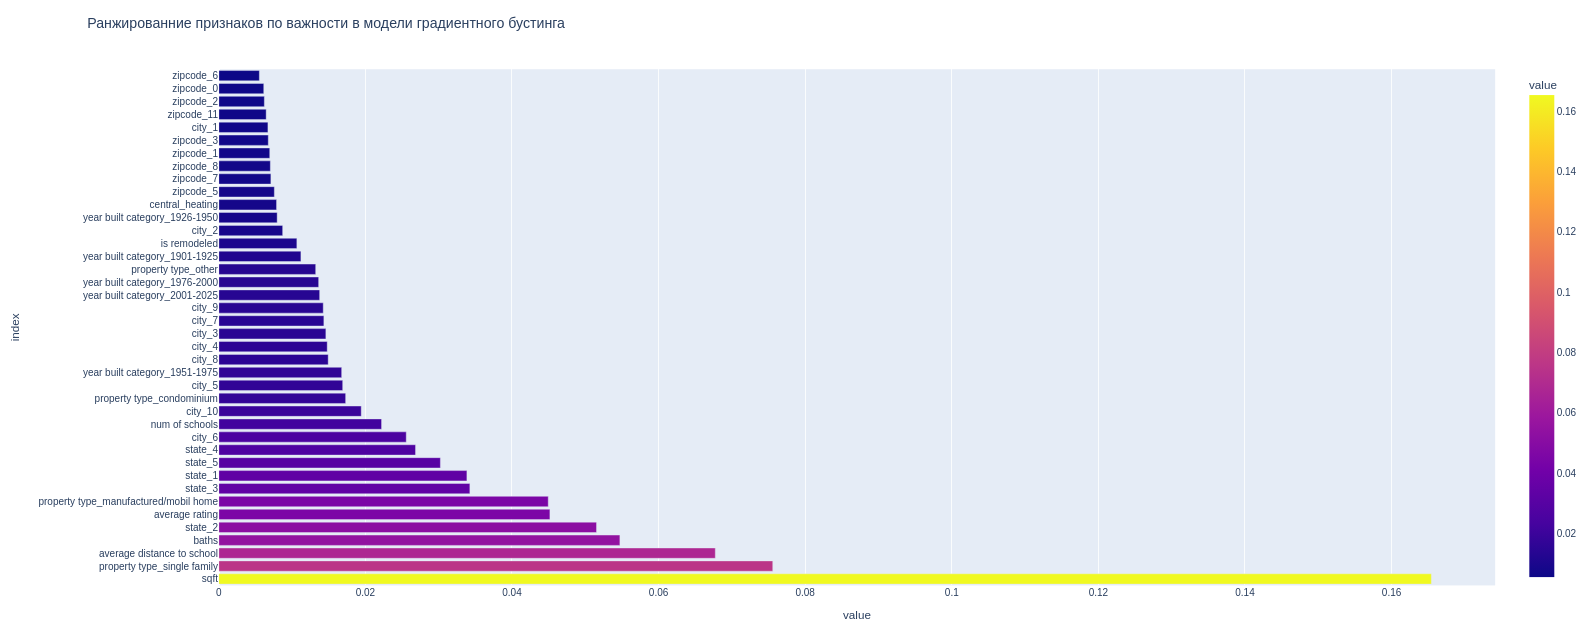

**Количество наблюдений - 128063, количество признаков - 40, диапазон таргета - 30000-769000$**

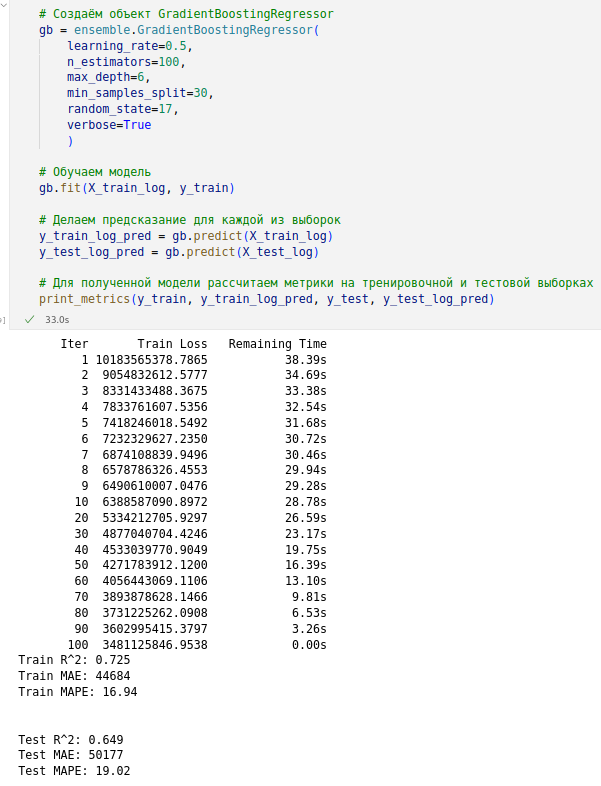

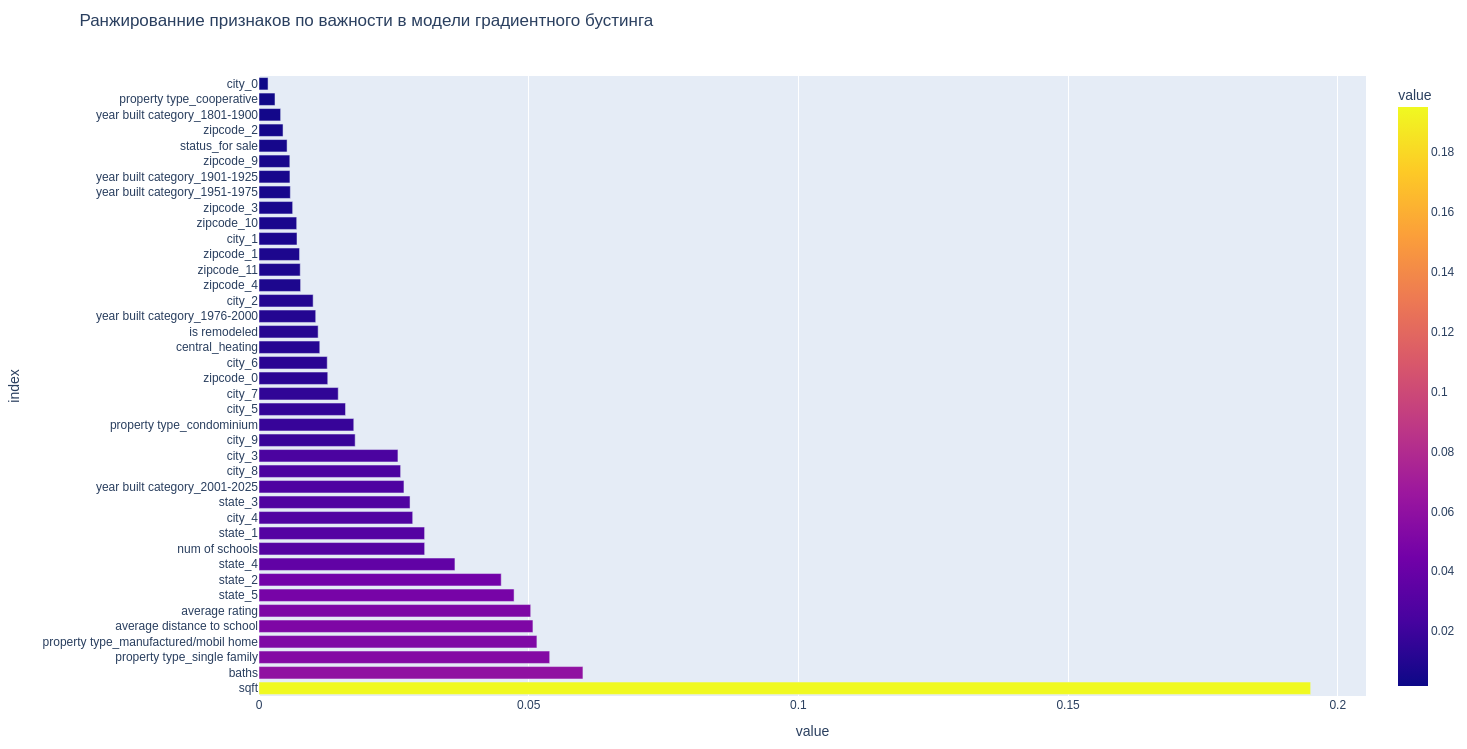

**Количество наблюдений - 128063, количество признаков - 48, диапазон таргета - 30000-769000$**

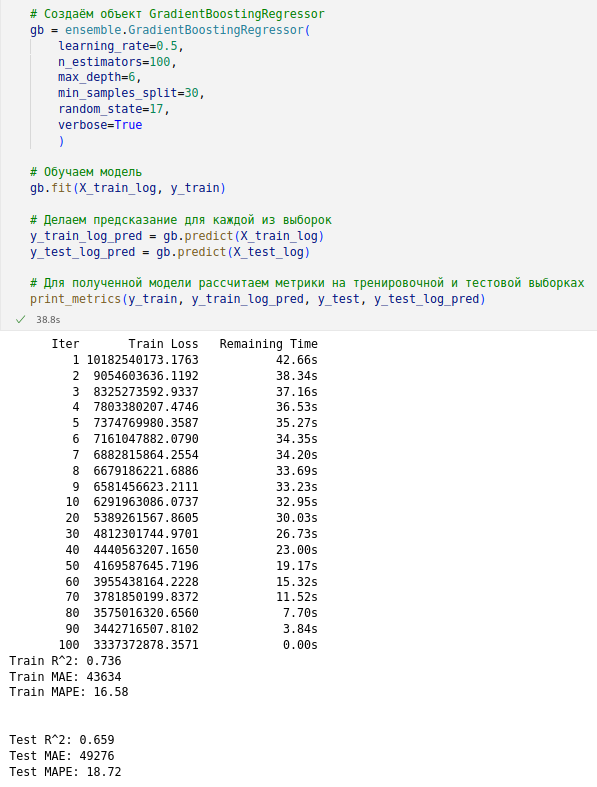
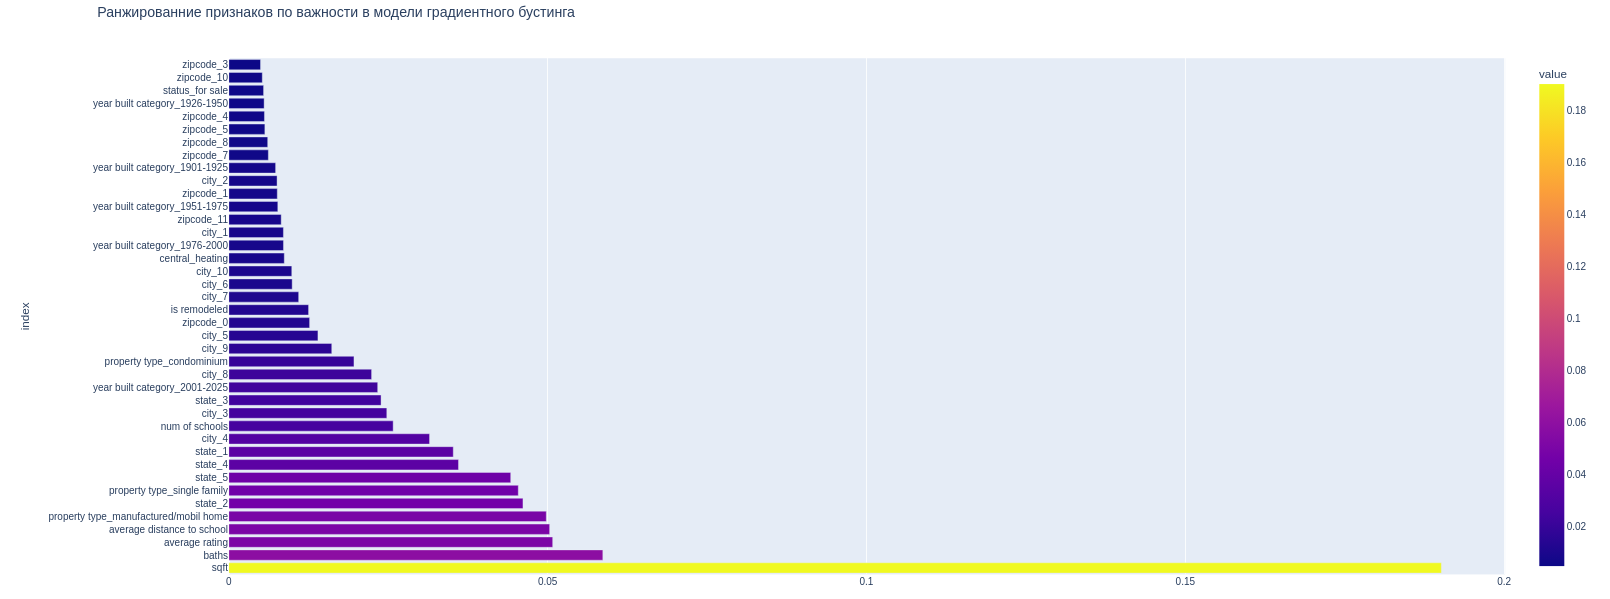

In [51]:
# Составим таблицу из полученных результатов 
result_data = pd.DataFrame({'model': ['GradientBoostingRegressor', 'GradientBoostingRegressor', 'GradientBoostingRegressor', 'GradientBoostingRegressor'],
                            'Parameters': ['learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=30, random_state=17',
                                           'learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=30, random_state=17',
                                           'learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=30, random_state=17',
                                           'learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=30, random_state=17'],
                            'M_features': [48, 48, 40, 48],
                            'N_rows': [136271, 133634, 128063, 128063],
                            'RobustScaler': [False, False, False, False],
                            'LogFeatures': [True, True, True, True], 
                            'Target': ['30000-1129000', '30000-975000', '30000-769000', '30000-769000'],
                            'R2_train': [0.764, 0.755, 0.725, 0.736],
                            'R2_test': [0.692, 0.678, 0.649, 0.659],
                            'MAE_train': [49798, 47390, 44684, 43634], 
                            'MAE_test': [55917, 53231, 50177, 49276],
                            'MAPE_train': [17.61, 17.13, 16.94, 16.58], 
                            'MAPE_test': [19.71, 19.13, 19.02, 18.72]
                            })
display(result_data)
# Посмотрим лучший результат по метрикe MAPE на тестовых данных:
print("\nЛучший результат по метрикe MAPE на тестовых данных:")
display(result_data[result_data['MAPE_test'] == result_data['MAPE_test'].min()])

# Посмотрим лучший результат по метрикe MAE на тестовых данных:
print("\nЛучший результат по метрикe MAE на тестовых данных:")
display(result_data[result_data['MAE_test'] == result_data['MAE_test'].min()])

# Посмотрим лучший результат по метрикe R2 на валидационных фолдах:
print("\nЛучший результат по метрикe R2 на тестовых данных:")
result_data[result_data['R2_test'] == result_data['R2_test'].max()]

model  \
0  GradientBoostingRegressor   
1  GradientBoostingRegressor   
2  GradientBoostingRegressor   
3  GradientBoostingRegressor   

                                          Parameters  M_features  N_rows  \
0  learning_rate=0.5, n_estimators=100, max_depth...          48  136271   
1  learning_rate=0.5, n_estimators=100, max_depth...          48  133634   
2  learning_rate=0.5, n_estimators=100, max_depth...          40  128063   
3  learning_rate=0.5, n_estimators=100, max_depth...          48  128063   

   RobustScaler  LogFeatures         Target  R2_train  R2_test  MAE_train  \
0         False         True  30000-1129000     0.764    0.692      49798   
1         False         True   30000-975000     0.755    0.678      47390   
2         False         True   30000-769000     0.725    0.649      44684   
3         False         True   30000-769000     0.736    0.659      43634   

   MAE_test  MAPE_train  MAPE_test  
0     55917       17.61      19.71  
1     53231       17.13      19.13  
2     50177       16.94      19.02  
3     49276       16.58      18.72


Лучший результат по метрикe MAPE на тестовых данных:


model  \
3  GradientBoostingRegressor   

                                          Parameters  M_features  N_rows  \
3  learning_rate=0.5, n_estimators=100, max_depth...          48  128063   

   RobustScaler  LogFeatures        Target  R2_train  R2_test  MAE_train  \
3         False         True  30000-769000     0.736    0.659      43634   

   MAE_test  MAPE_train  MAPE_test  
3     49276       16.58      18.72


Лучший результат по метрикe MAE на тестовых данных:


model  \
3  GradientBoostingRegressor   

                                          Parameters  M_features  N_rows  \
3  learning_rate=0.5, n_estimators=100, max_depth...          48  128063   

   RobustScaler  LogFeatures        Target  R2_train  R2_test  MAE_train  \
3         False         True  30000-769000     0.736    0.659      43634   

   MAE_test  MAPE_train  MAPE_test  
3     49276       16.58      18.72


Лучший результат по метрикe R2 на тестовых данных:


model  \
0  GradientBoostingRegressor   

                                          Parameters  M_features  N_rows  \
0  learning_rate=0.5, n_estimators=100, max_depth...          48  136271   

   RobustScaler  LogFeatures         Target  R2_train  R2_test  MAE_train  \
0         False         True  30000-1129000     0.764    0.692      49798   

   MAE_test  MAPE_train  MAPE_test  
0     55917       17.61      19.71

> *Как видно из приведённых выше результатов, с ростом числа наблюдений и диапазона целевой переменной увеличивался коэффициент детерминации и ухудшались MAE и MAPE. А также уменьшение числа признаков приводило к ухудшению качества предсказания.*

## 8. Сoхраниение обученной модели.

Создадим пайплайн, который включает предобработку, нормализацию, отбор признаков и обучение модели.
Подготовим данные для тестирования пайплайна

In [52]:
dtype_dict = {
   'status': 'object',
   'baths': 'float',
   'city': 'object',
   'sqft': 'int16',  
   'zipcode': 'object',
   'state': 'object', 
   'target': 'int32',  
   'property_type': 'object',
   'year_built_category': 'object', 
   'is_remodeled': 'int8',   
   'central_heating': 'int8', 
   'num_of_schools': 'int8',  
   'average_rating': 'int8',
   'average_distance_to_school': 'int8'   
} 
  
data_p = pd.read_csv('data/cleaned_data.csv', dtype=dtype_dict)

X_p = data_p.drop(['target'], axis=1)
y_p = data_p['target']

# Разделяем выборку на тренировочную и тестовую в соотношении 67/33
X_train_p, X_test_p, y_train_p, y_test_p = model_selection.train_test_split(X_p, y_p, test_size = 0.33, random_state=17)
display(X_train_p.head())

status  baths            city  sqft zipcode state  \
115487  for sale    4.5    huntersville  3676   28078    NC   
67576   for sale    2.0  bonita springs  1654   34135    FL   
111432  for sale    2.0     punta gorda  1820   33950    FL   
72050   for sale    2.0    jacksonville  1229   32254    FL   
108254  for sale    2.0     gainesville  1472   32609    FL   

                  property_type year_built_category  is_remodeled  \
115487            single family           2001-2025             0   
67576               condominium           2001-2025             1   
111432            single family           1976-2000             0   
72050             single family           2001-2025             0   
108254  manufactured/mobil home           1976-2000             1   

        num_of_schools  average_rating  average_distance_to_school  \
115487               8               8                           3   
67576                6               6                           9   
111432               7               6                           3   
72050                8               5                           1   
108254               3               4                           5   

        central_heating  
115487                0  
67576                 1  
111432                0  
72050                 0  
108254                0

In [57]:
# Создаём пайплайн, который включает нормализацию, отбор признаков и обучение модели
ct = make_column_transformer(
    (preprocessing.OneHotEncoder(drop='first'), ['property_type', 'year_built_category', 'status']),
    (ce.BinaryEncoder(), ['city', 'zipcode', 'state']),
    (preprocessing.RobustScaler(), ['baths', 'sqft', 'num_of_schools', 'average_rating', 'average_distance_to_school']),
    remainder='passthrough'
)
print(ct)

pipe = Pipeline([
    ('ct', ct),
    ('FeatureSelection', feature_selection.SelectKBest(
        feature_selection.f_regression,
        k=40)),
    ('GBRegressor', ensemble.GradientBoostingRegressor(
        learning_rate=0.5, 
        n_estimators=100,
        max_depth=6,
        min_samples_split=30,
        random_state=17,
        verbose=True))
])

# Обучаем пайплайн
pipe.fit(X_train_p, y_train_p)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 ['property_type', 'year_built_category',
                                  'status']),
                                ('binaryencoder', BinaryEncoder(),
                                 ['city', 'zipcode', 'state']),
                                ('robustscaler', RobustScaler(),
                                 ['baths', 'sqft', 'num_of_schools',
                                  'average_rating',
                                  'average_distance_to_school'])])
      Iter       Train Loss   Remaining Time 
         1  9804132901.4658           36.53s
         2  8673444147.1445           35.32s
         3  7869069723.5953           34.73s
         4  7433630765.9011           33.61s
         5  7166114131.7061           32.19s
         6  6896309222.8775           31.89s
         7  6703010349.5413           31.39s
         8  6

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['property_type',
                                                   'year_built_category',
                                                   'status']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['city', 'zipcode', 'state']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['baths', 'sqft',
                                                   'num_of_schools',
                                                   'average_rating',
                                                   'average_distance_to_school'])])),
                ('FeatureSelection',
                 SelectKBest(k=40,
                             score_func=<function f_regression at 0x7fc9dc129bd0>)),
                ('GBRegressor',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=6,
                                           min_samples_split=30,
                                           random_state=17, verbose=True))])

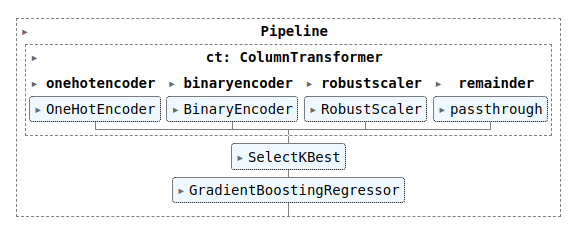

Сохраним обученный пайплайн в файл с помощью pickle.

In [58]:
# Сериализуем pipeline и записываем результат в файл
with open("models/best_gb_model.pkl", 'wb') as output:
    pickle.dump(pipe, output)

Восстанавливаем модель из файла.

In [59]:
# Десериализуем pipeline из файла
with open("models/best_gb_model.pkl", 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

Выберем тестовую строку, которую подадим на вход пайплайну, сделаем предсказание и визуально сверим его с правильным ответом.

In [60]:
print("Тестовая строка:")
display(X_test_p[0:1])
print(f"\nПредсказание: {np.round(pipe.predict(X_test_p[0:1])[0])}")
print(f"Правильный ответ: {y_test_p.iloc[0]}")

Тестовая строка:


status  baths          city  sqft zipcode state property_type  \
46598  for sale    2.0  howard beach  1020   11414    NY   condominium   

      year_built_category  is_remodeled  num_of_schools  average_rating  \
46598           1951-1975             1               3               6   

       average_distance_to_school  central_heating  
46598                           1                0


Предсказание: 384910.0
Правильный ответ: 379999


Модель воспроизводится.

Наш пайплайн принимает на вход очищенные данные, также оставляет сильно скореллированные признаки, полученные уже после кодирования. Можно добавить в пайплайн класс, который удаляет такие признаки, например:

```
class CorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
     
    def fit(self, X, y=None):
        correlation_matrix = X.corr().abs()
        upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
        self.high_correlation_features = [column for column in upper_tri.columns if any(upper_tri[column] > self.threshold)]
        return self
     
    def transform(self, X, y=None):
        return X.drop(columns=self.high_correlation_features)

pipeline = Pipeline([
    ('correlation_remover', CorrelationRemover(threshold=0.9))
])
```

Чтобы подавать на вход грязные данные, необходимо учесть все трудоёмкие и затратные по времени преобразования, сделанные в первой части проекта. Самоё простое и оптимальное решение - сервис должен принимать на вход данные в соответствии допустимым форматом полей, а для текстовых факторов - с категориями из выпадающего списка.